In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_ta as ta

In [2]:
nifty_50 = pd.read_excel("nifty_50.xlsx")['SYMBOL \n'].to_list()

In [3]:
nifty_50

['EICHERMOT',
 'M&M',
 'SHRIRAMFIN',
 'TATAMOTORS',
 'TECHM',
 'ONGC',
 'JSWSTEEL',
 'SBIN',
 'HCLTECH',
 'HINDALCO',
 'BPCL',
 'RELIANCE',
 'INFY',
 'SBILIFE',
 'GRASIM',
 'DRREDDY',
 'COALINDIA',
 'ASIANPAINT',
 'LT',
 'TCS',
 'BAJAJFINSV',
 'TITAN',
 'BAJAJ-AUTO',
 'WIPRO',
 'TATASTEEL',
 'HEROMOTOCO',
 'LTIM',
 'ADANIPORTS',
 'BHARTIARTL',
 'POWERGRID',
 'APOLLOHOSP',
 'NESTLEIND',
 'BAJFINANCE',
 'NTPC',
 'ADANIENT',
 'ICICIBANK',
 'ULTRACEMCO',
 'HDFCBANK',
 'HINDUNILVR',
 'TATACONSUM',
 'AXISBANK',
 'INDUSINDBK',
 'ITC',
 'CIPLA',
 'BRITANNIA',
 'DIVISLAB',
 'SUNPHARMA',
 'MARUTI',
 'KOTAKBANK',
 'HDFCLIFE']

In [4]:
import datetime as dt

today = dt.date.today()
lookback = 715 #days


end_date = today.strftime("%Y-%m-%d")
start_date = (today - dt.timedelta(days=lookback)).strftime("%Y-%m-%d")



In [5]:
data = {
    ticker: yf.download(
        f'{ticker}.NS', interval="1h", start=start_date, end=end_date
    )
    for ticker in nifty_50
}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [6]:
help(ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)

    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.

    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/

    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal

        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
            Histogram = MA

In [20]:
import pandas as pd
import pandas_ta as ta

def ema_VWMA_strategy_with_pivot(df, ticker):
    """
    This function implements the EMA-VWMA trading strategy with Pivot levels and CPR condition.
    
    Parameters:
    - df: DataFrame containing the stock data with OHLC and Volume.
    - ticker: The ticker symbol for the stock (used in plotting).
    
    Returns:
    - df: DataFrame with calculated signals and strategy performance metrics.
    - trades_df: DataFrame with time, price of entry, price of exit, and profit for each trade.
    """
    # Ensure the DataFrame index is a DatetimeIndex

    # Resample the data to daily OHLC (Open, High, Low, Close)
    df_daily = df.resample('D').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'
    }).dropna()

    # Calculate daily pivot points
    df_daily['Pivot Point'] = (df_daily['High'] + df_daily['Low'] + df_daily['Close']) / 3
    df_daily['TC'] = (df_daily['Pivot Point'] * 2) - df_daily['Low']  # Top Central Pivot
    df_daily['BC'] = (df_daily['Pivot Point'] * 2) - df_daily['High']  # Bottom Central Pivot
    df_daily['CPR Width'] = df_daily['TC'] - df_daily['BC']  # Calculate CPR width
    df_daily['Date'] = df_daily.index.date
    df['Date'] = df.index.date
    df['EMA_10'] = ta.ema(df['Close'], length=10)
    df['EMA_20'] = ta.ema(df['Close'], length=20)

    # Calculate VWAP using pandas_ta
    df['VWMA'] = ta.vwma(df['Close'], df['Volume'],length=10)

    # Calculate MACD using pandas_ta
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df = pd.concat([df, macd], axis=1)

    # Calculate RSI using pandas_ta
    df['RSI'] = ta.rsi(df['Close'], length=14)


    # Filter the results to only include necessary columns
    df_daily_cpr = df_daily[['Pivot Point', 'TC', 'BC', 'CPR Width', 'Date']]
    
    # Merge daily CPR data with the intraday data
    df_merged = pd.merge(df, df_daily_cpr, on='Date', how='left')

    # Debug: Print columns after merge
    print("Columns after merge:", df_merged.columns)

    # Drop the 'Date' column as it's no longer needed after the merge
    df_merged = df_merged.drop(columns=['Date'])

    # Ensure the 'TC' and 'BC' columns exist before forward filling
    if 'TC' in df_merged.columns:
        df_merged['TC'] = df_merged['TC'].ffill()
    else:
        print("Error: 'TC' column not found after merging. Check your data.")

    if 'BC' in df_merged.columns:
        df_merged['BC'] = df_merged['BC'].ffill()
    else:
        print("Error: 'BC' column not found after merging. Check your data.")

    # Calculate CPR (Central Pivot Range)
    df_merged['CPR'] = df_merged['TC'] - df_merged['BC']

    # Ensure df_merged has a DatetimeIndex
    if not isinstance(df_merged.index, pd.DatetimeIndex):
        df_merged.index = pd.to_datetime(df_merged.index)

    # Filter the DataFrame for the desired trading time window
    df_merged = df_merged.between_time('09:20', '15:15')

    # Calculate EMA using pandas_ta

    # Generate buy/sell signals based on conditions (example condition below)
    df_merged['Signal'] = 0
    df_merged['Signal'] = df_merged.apply(
        lambda row: 1 if (row['EMA_10'] > row['EMA_20']) and (row['Close'] > row['VWMA']) and (row['CPR'] < 0.25) else -1 if (row['EMA_10'] < row['EMA_20']) and (row['Close'] < row['VWMA']) and (row['CPR'] < 0.25) else 0, axis=1
    )

    # Create a DataFrame for trades
    trades = []
    position = 0
    entry_price = 0

    for index, row in df_merged.iterrows():
        if row['Signal'] == 1 and position == 0:
            position = 1
            entry_price = row['Close']
            trades.append({'Time': index, 'Entry Price': entry_price})
        elif row['Signal'] == -1 and position == 1:
            position = 0
            exit_price = row['Close']
            profit = exit_price - entry_price
            trades[-1].update({'Exit Price': exit_price, 'Profit': profit})

    trades_df = pd.DataFrame(trades)
    
    return df_merged, trades_df


In [21]:
eich_df = ema_vwap_strategy_with_pivot(data['EICHERMOT'], 'EICHERMOT')

Columns after merge: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date',
       'Pivot Point', 'TC', 'BC', 'CPR Width'],
      dtype='object')


UnboundLocalError: cannot access local variable 'ordered' where it is not associated with a value

In [13]:
eich_df

NameError: name 'eich_df' is not defined

In [ ]:
eich_df[1]

,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit


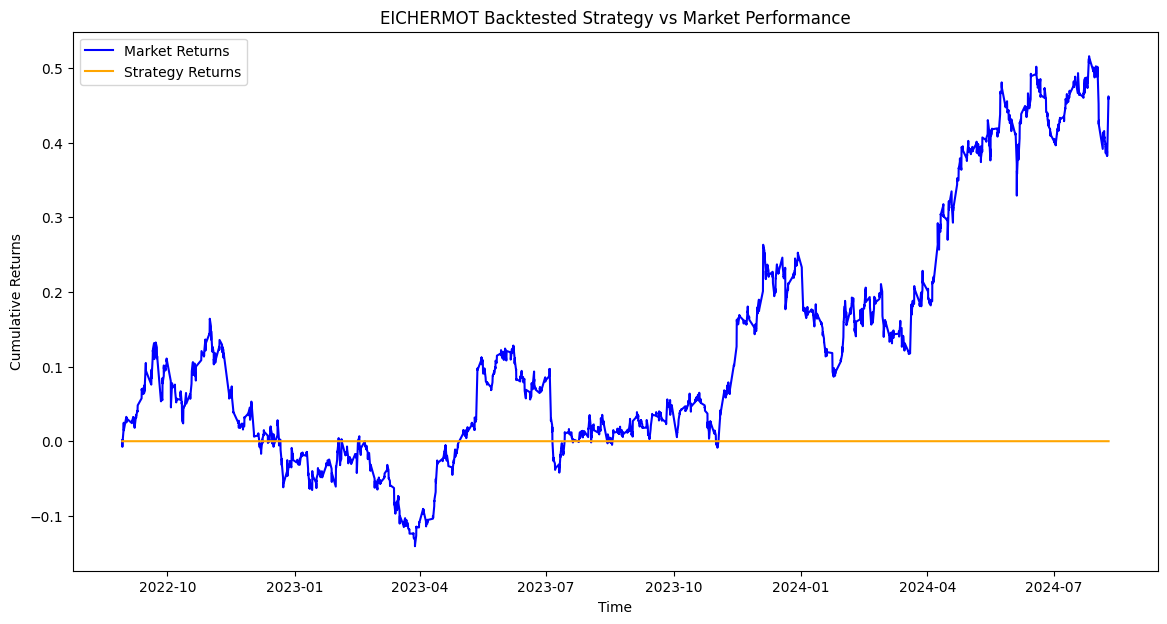

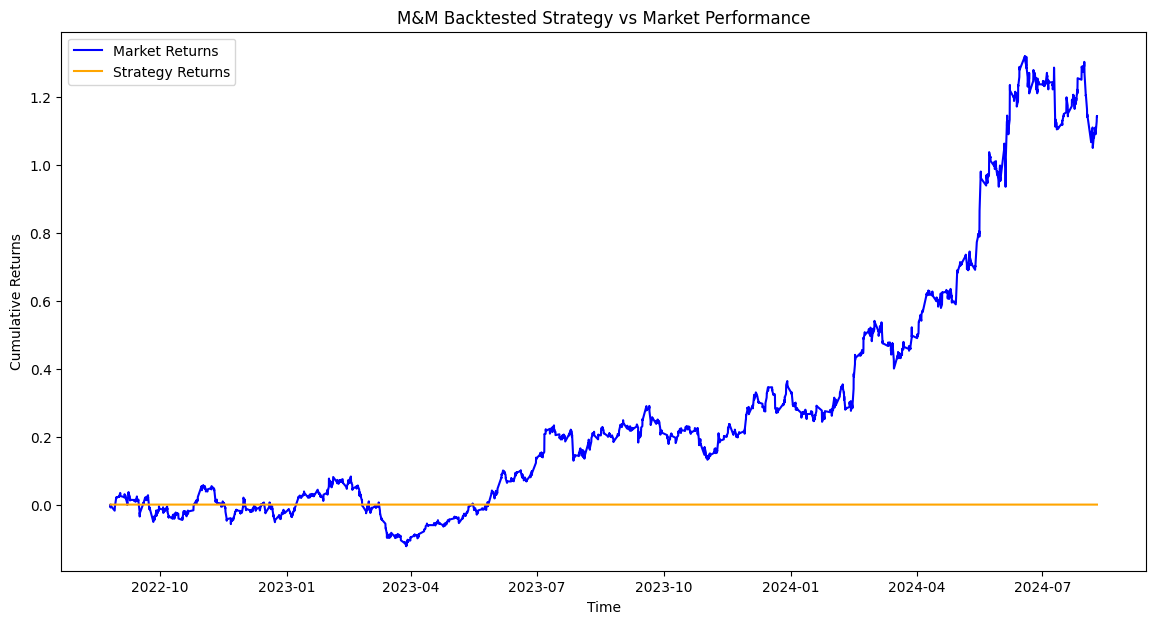

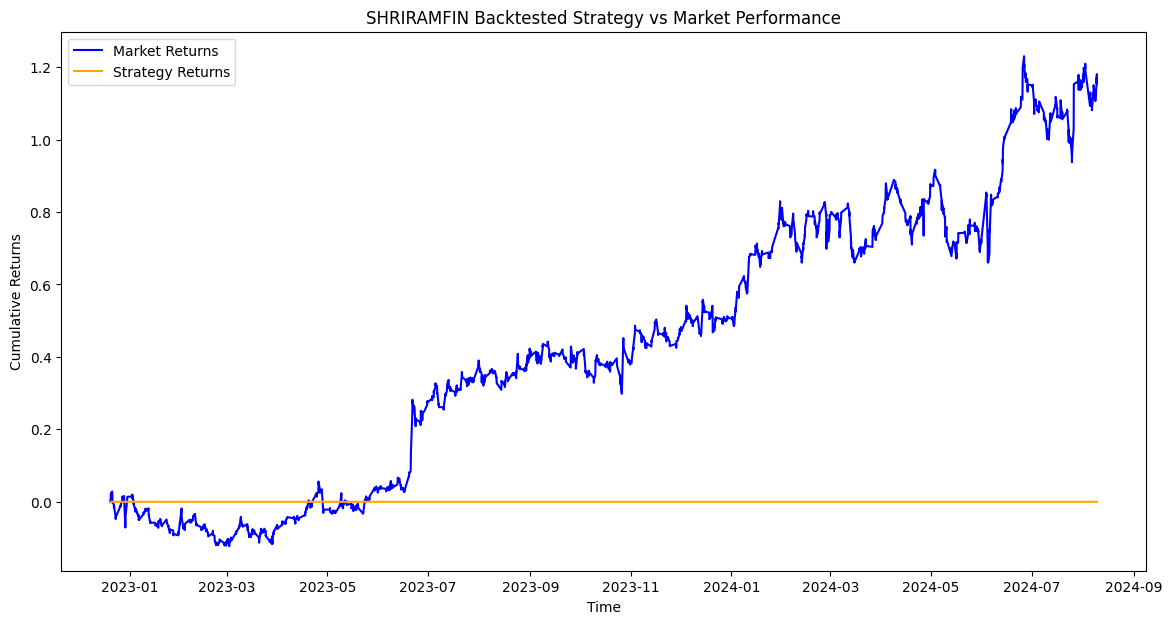

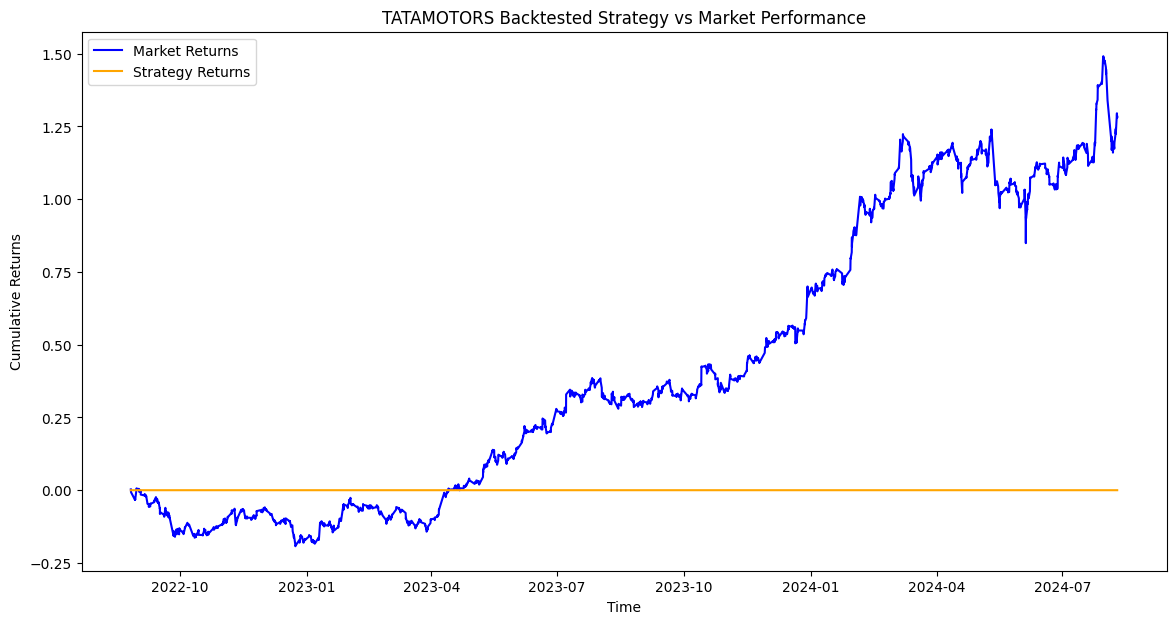

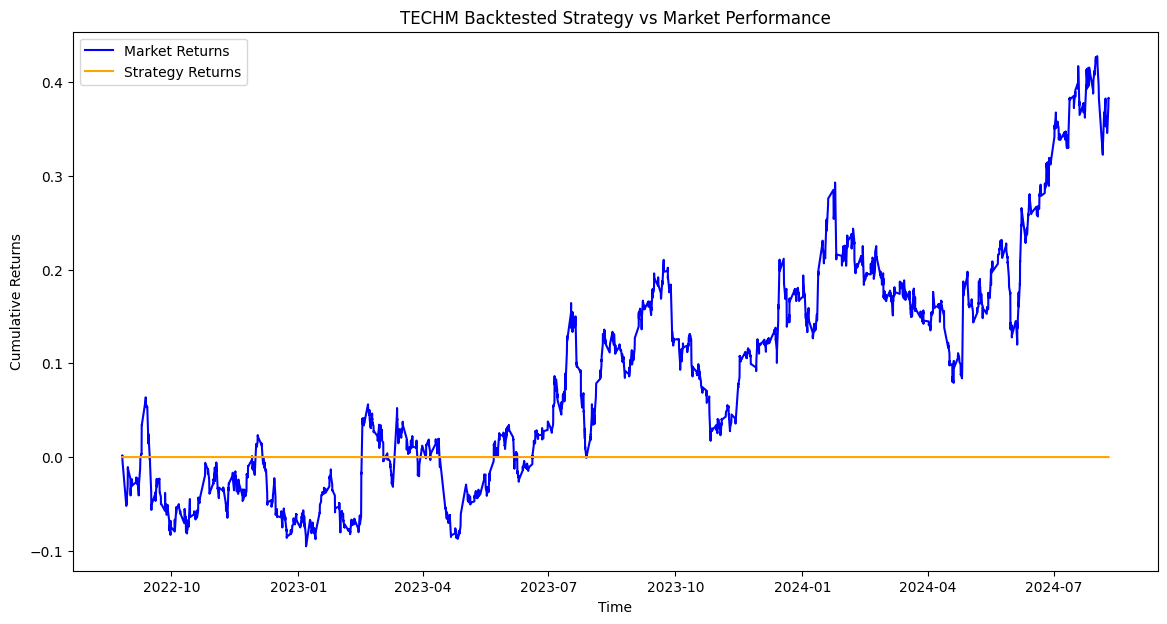

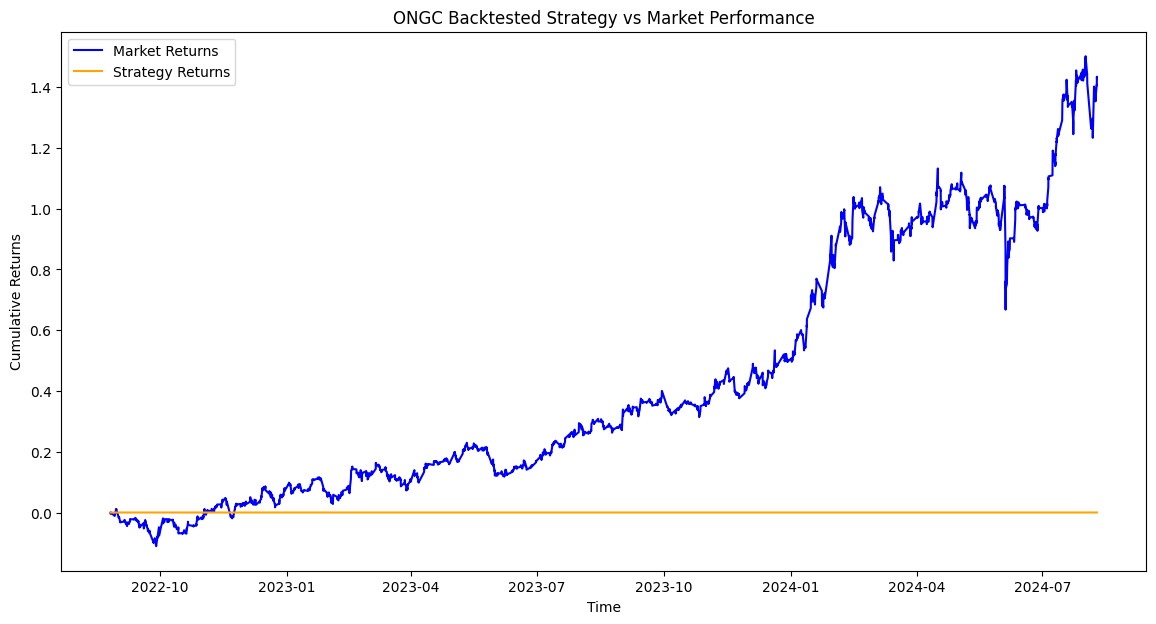

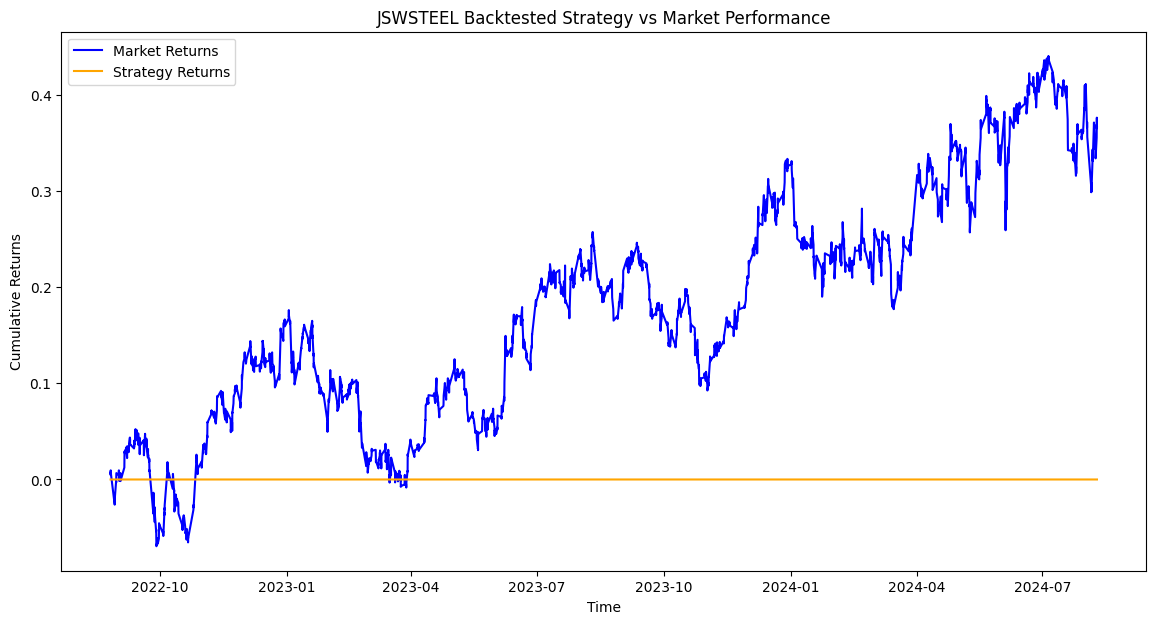

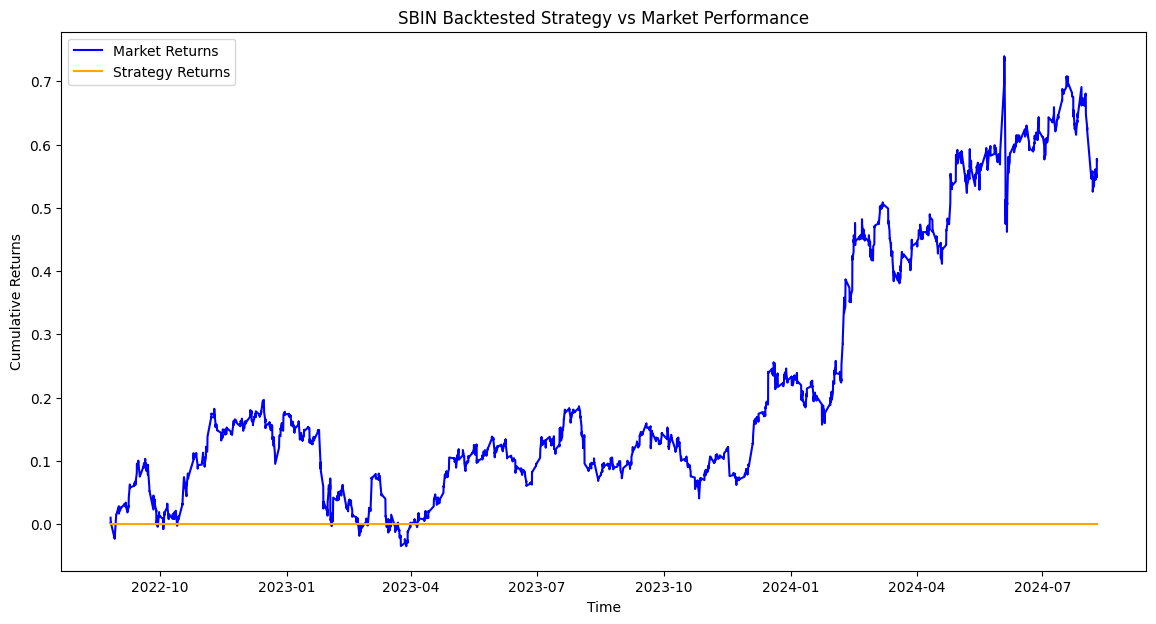

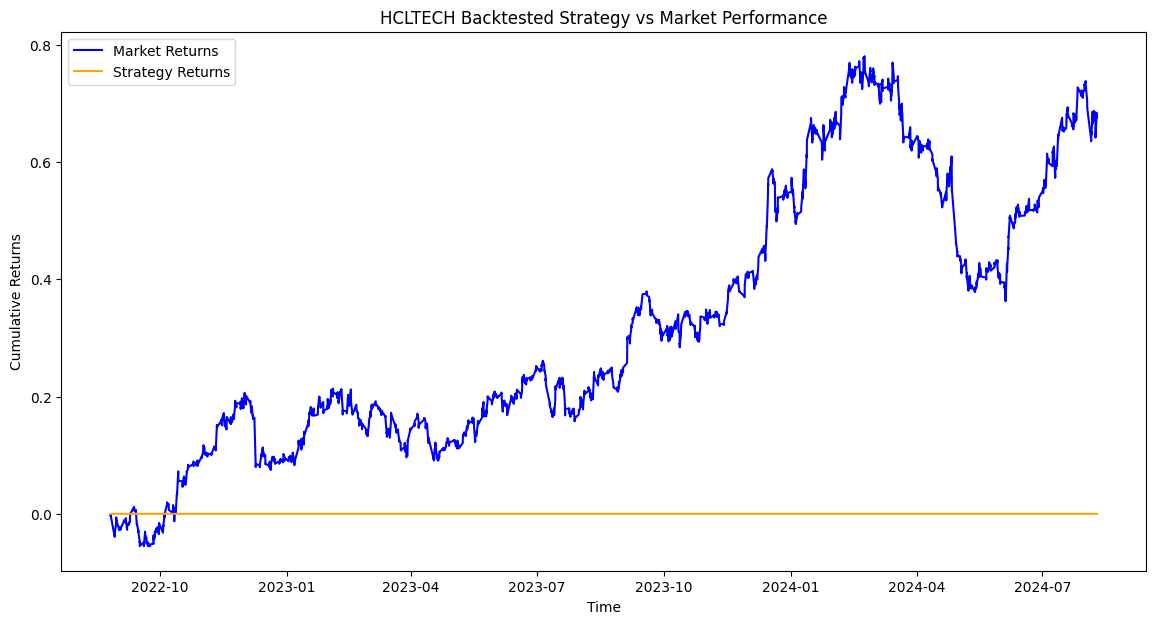

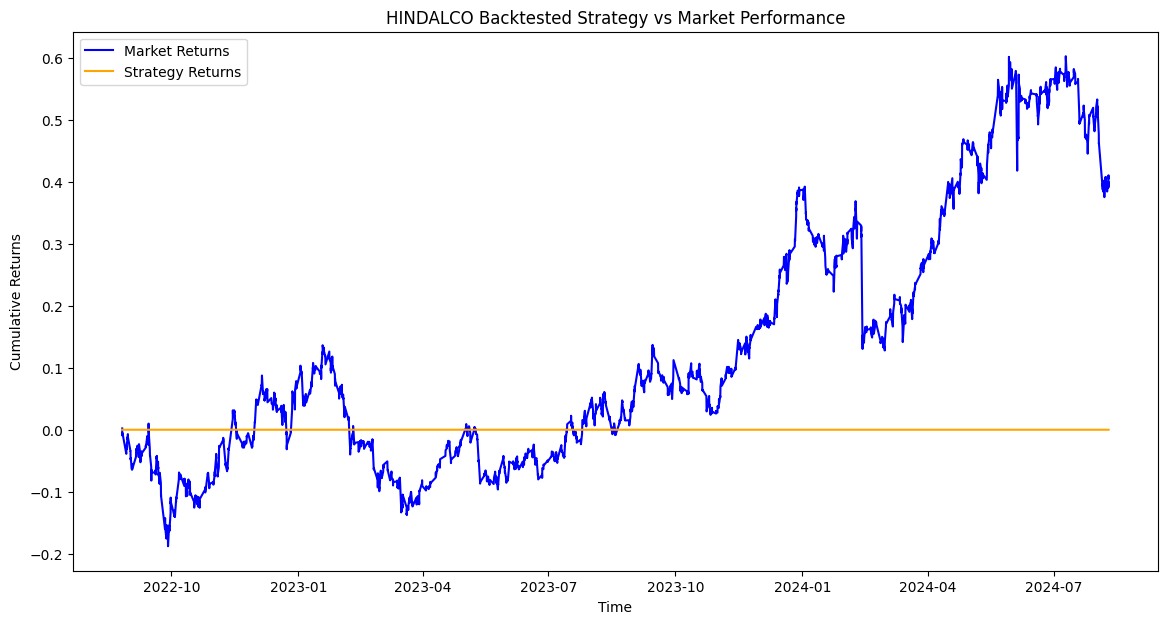

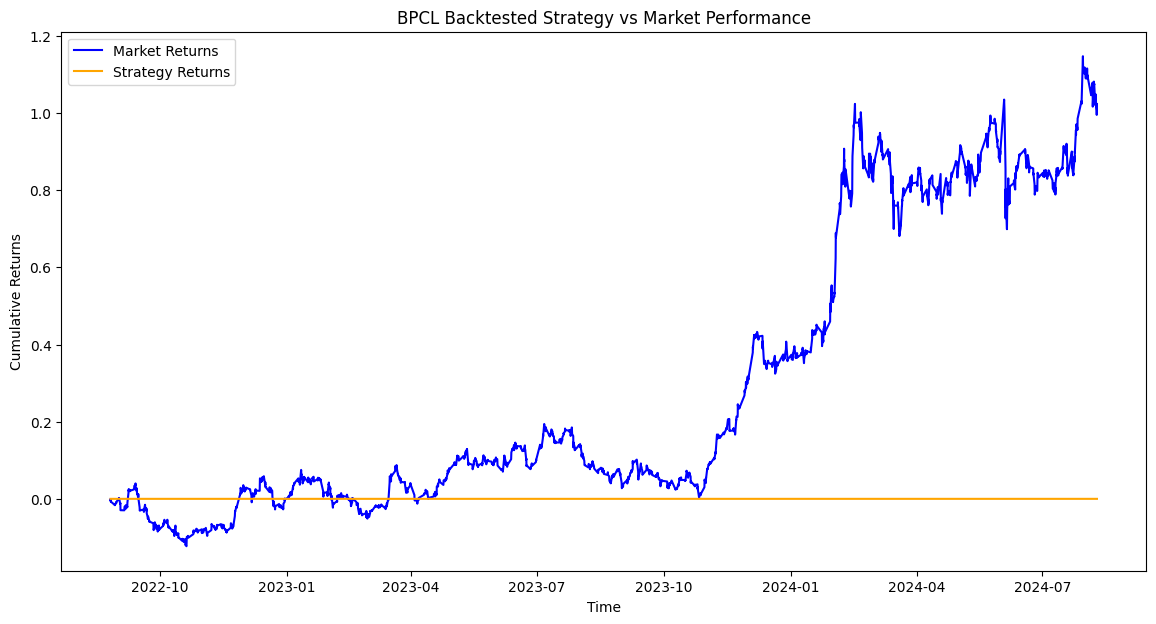

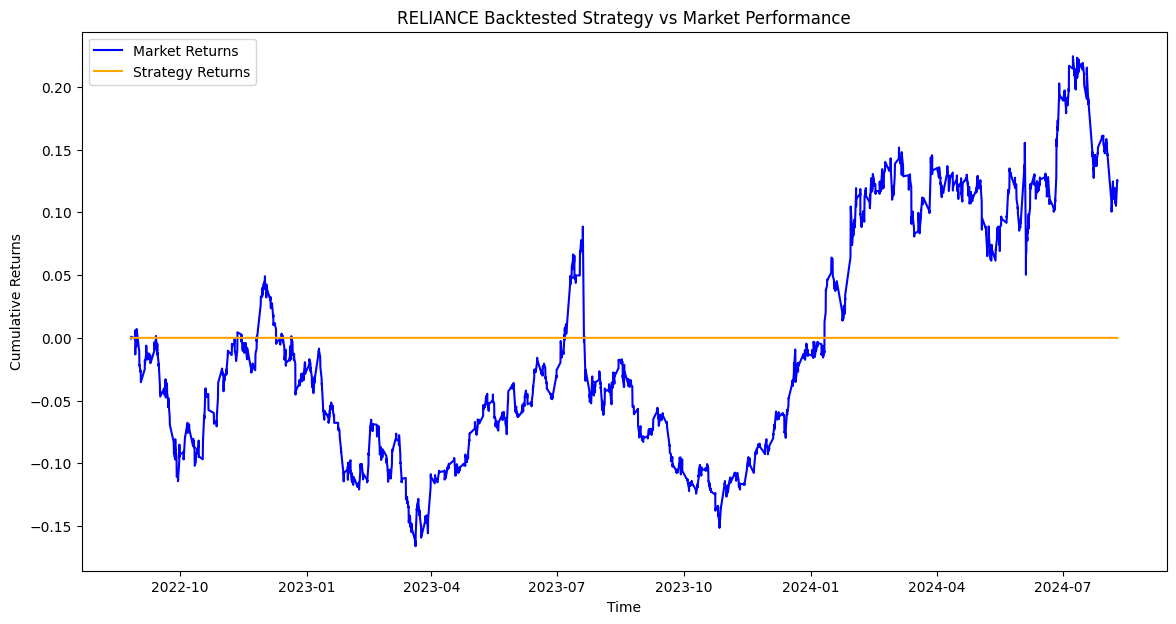

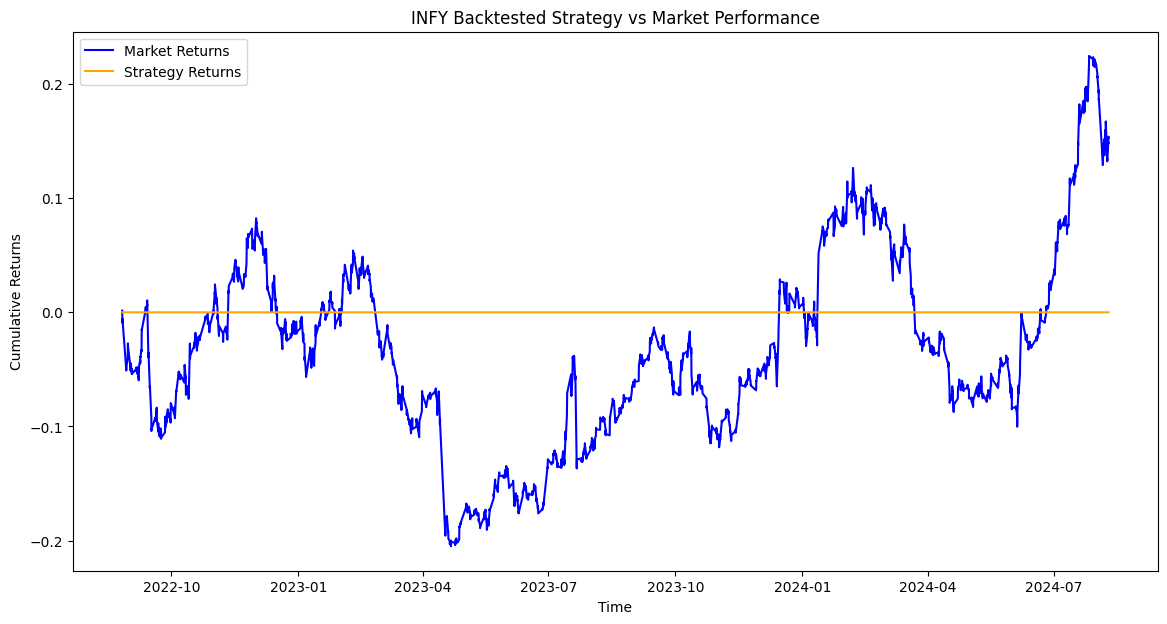

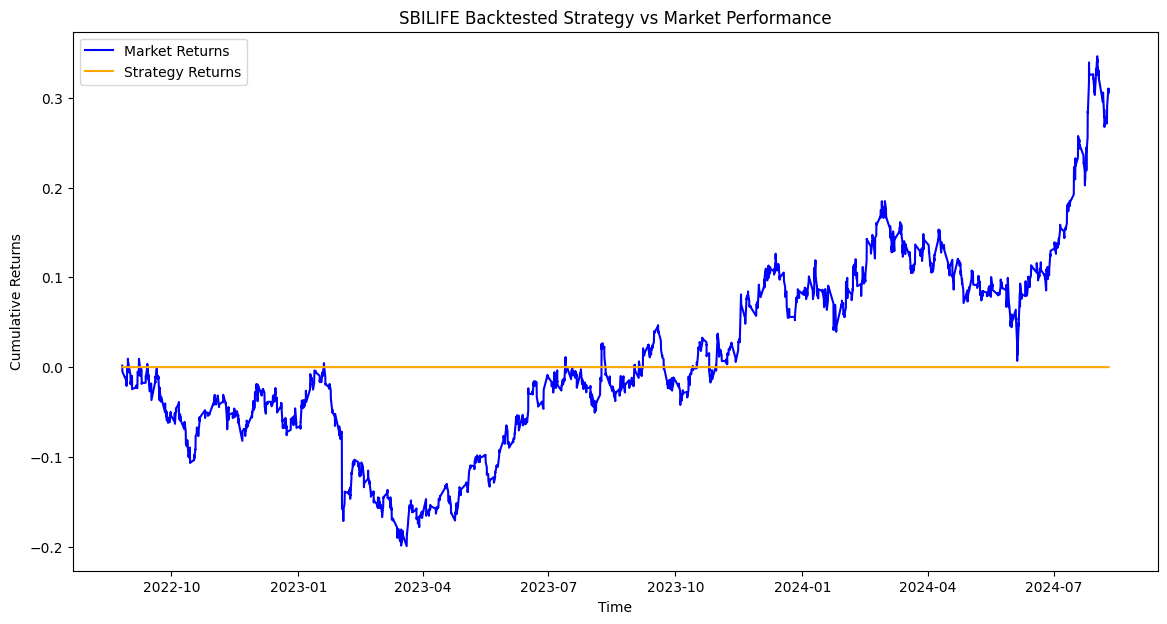

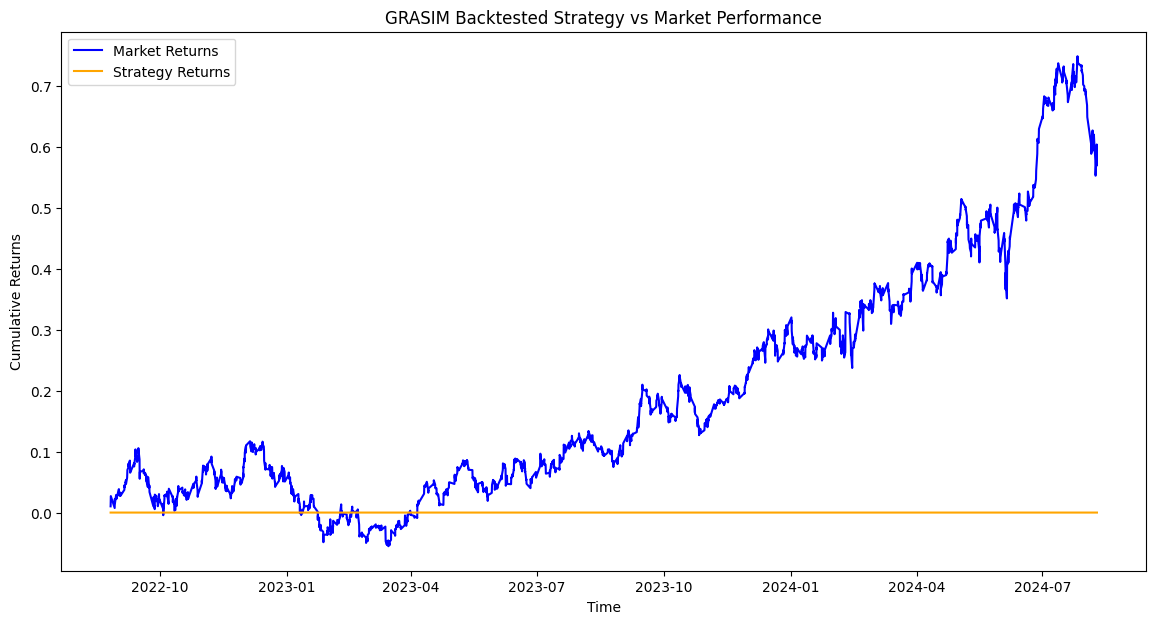

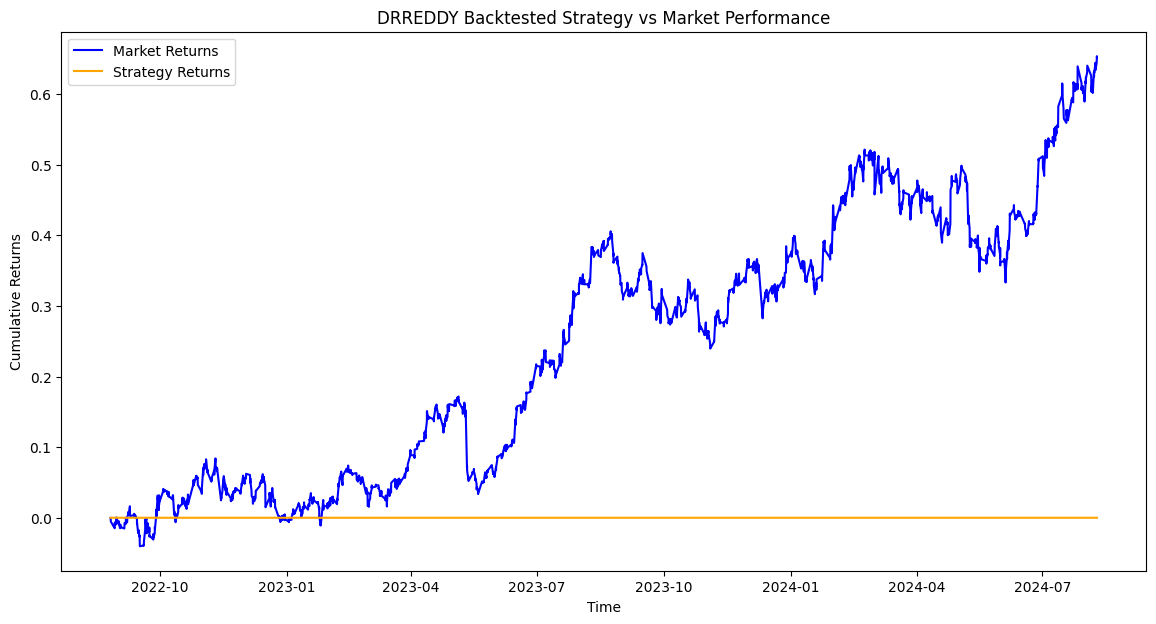

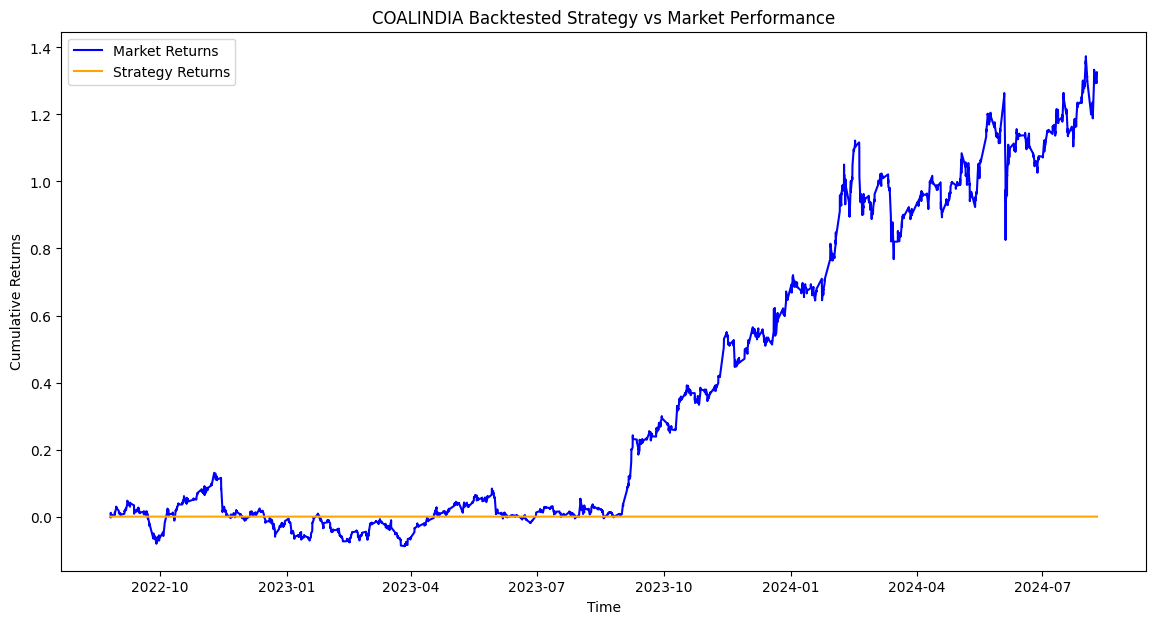

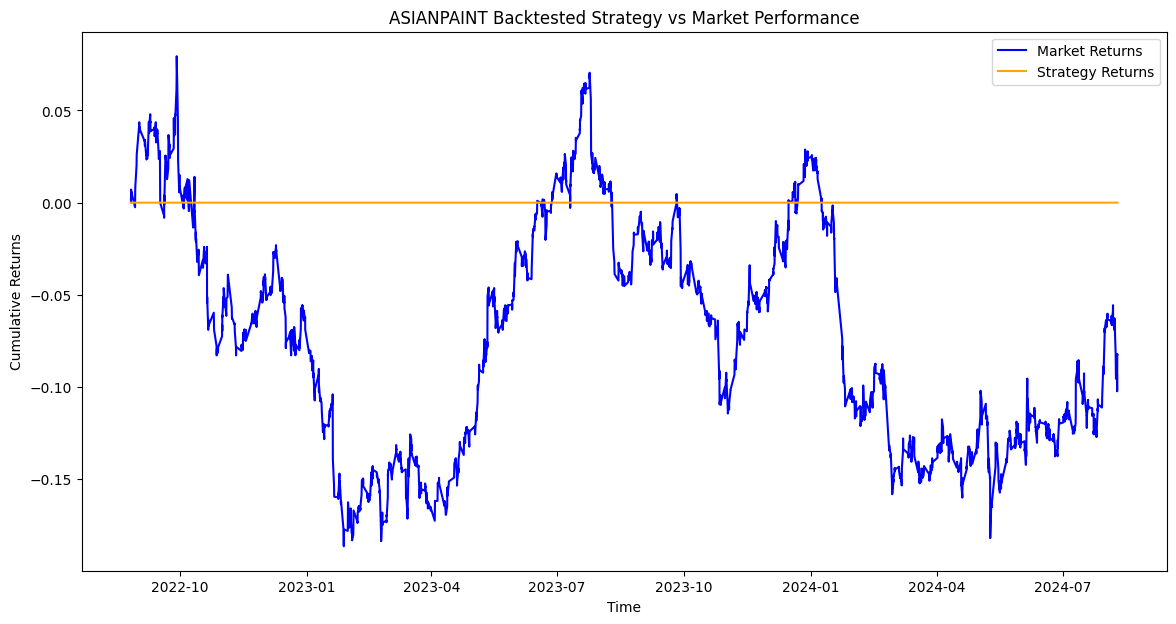

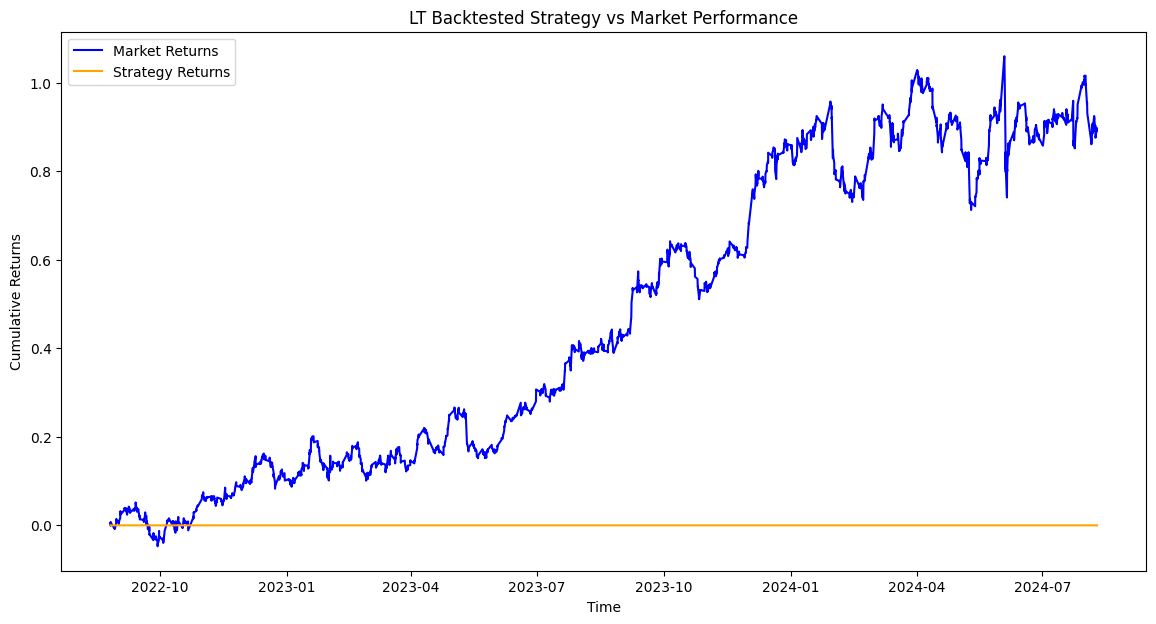

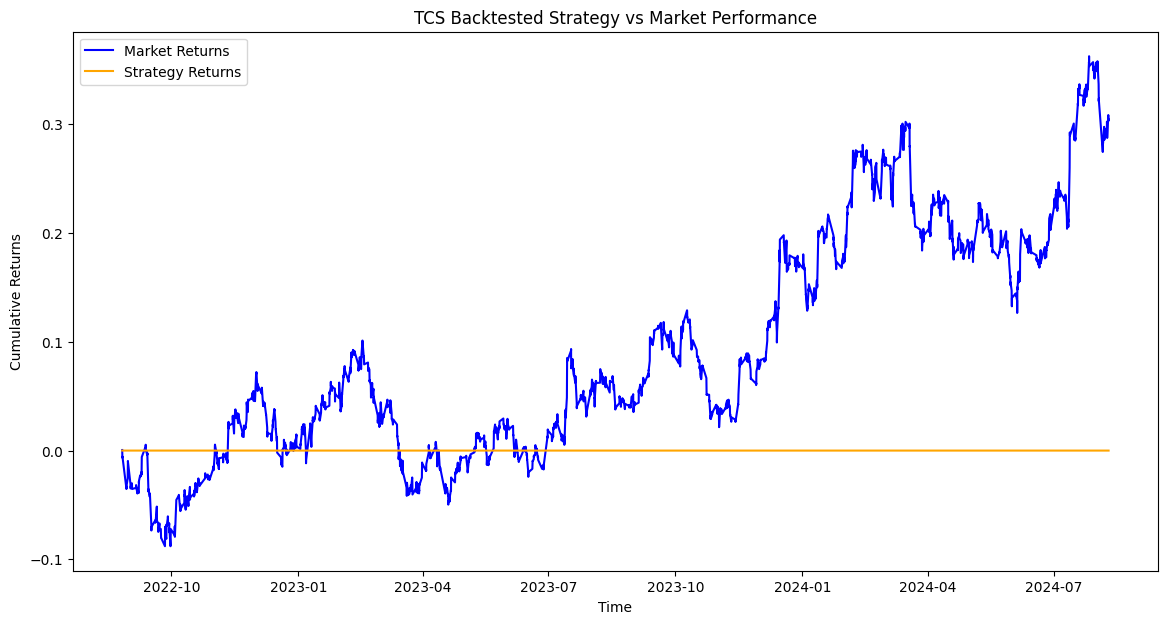

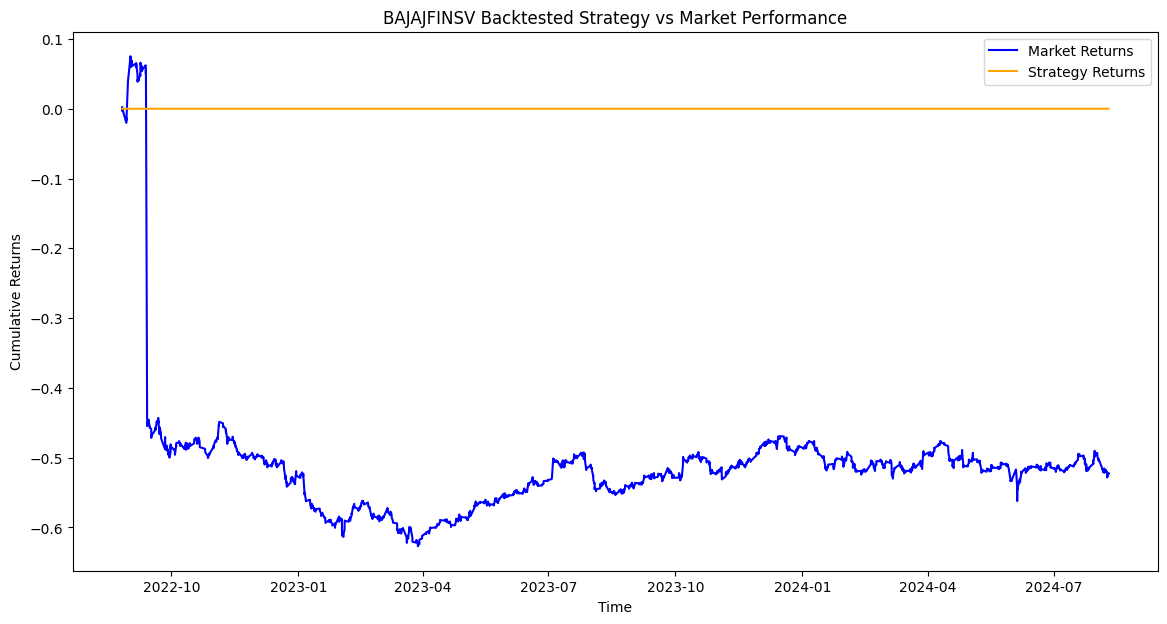

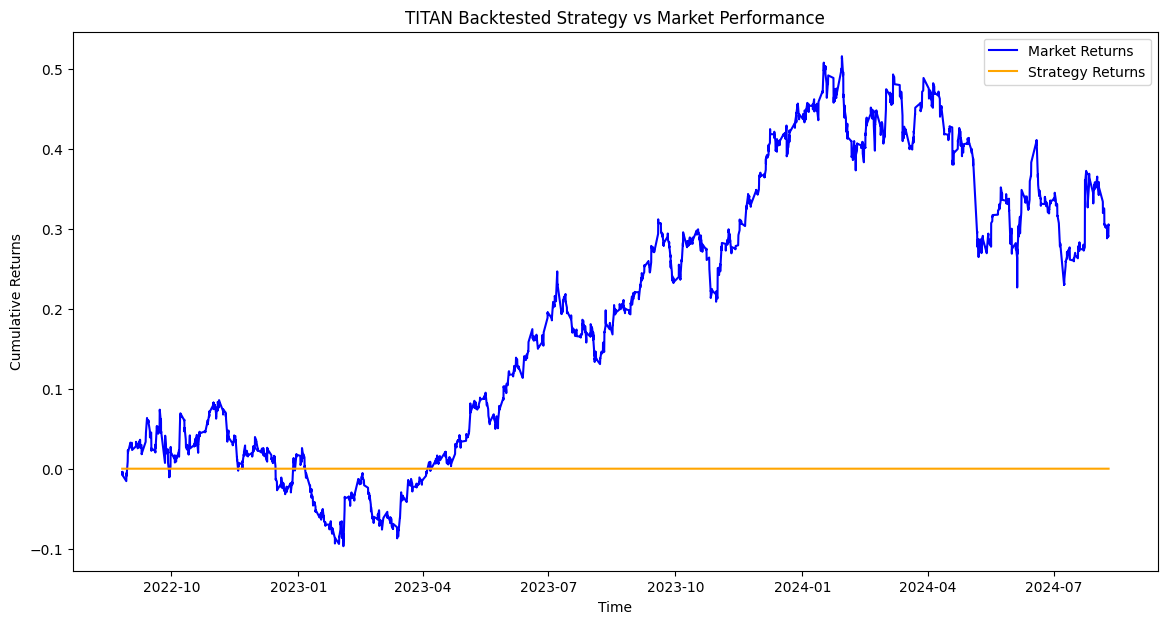

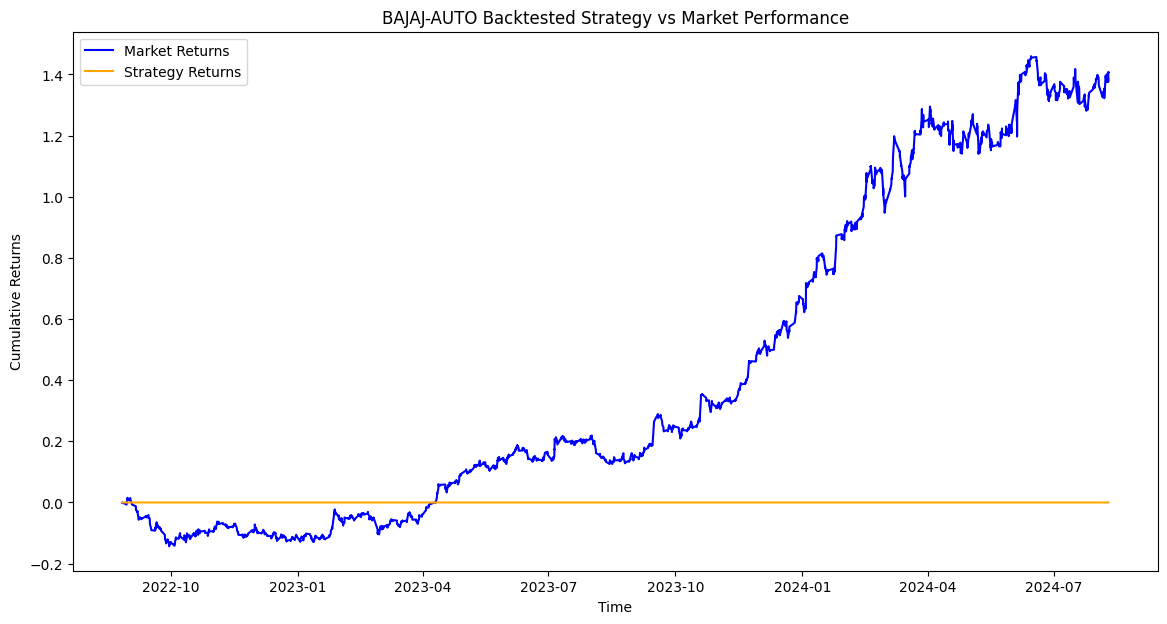

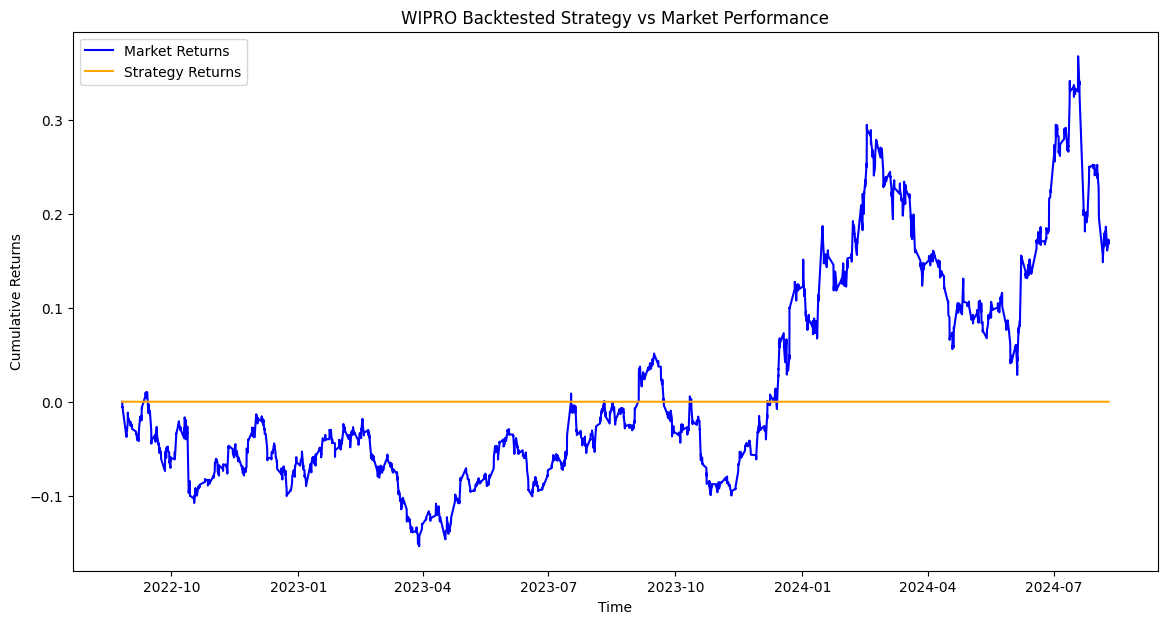

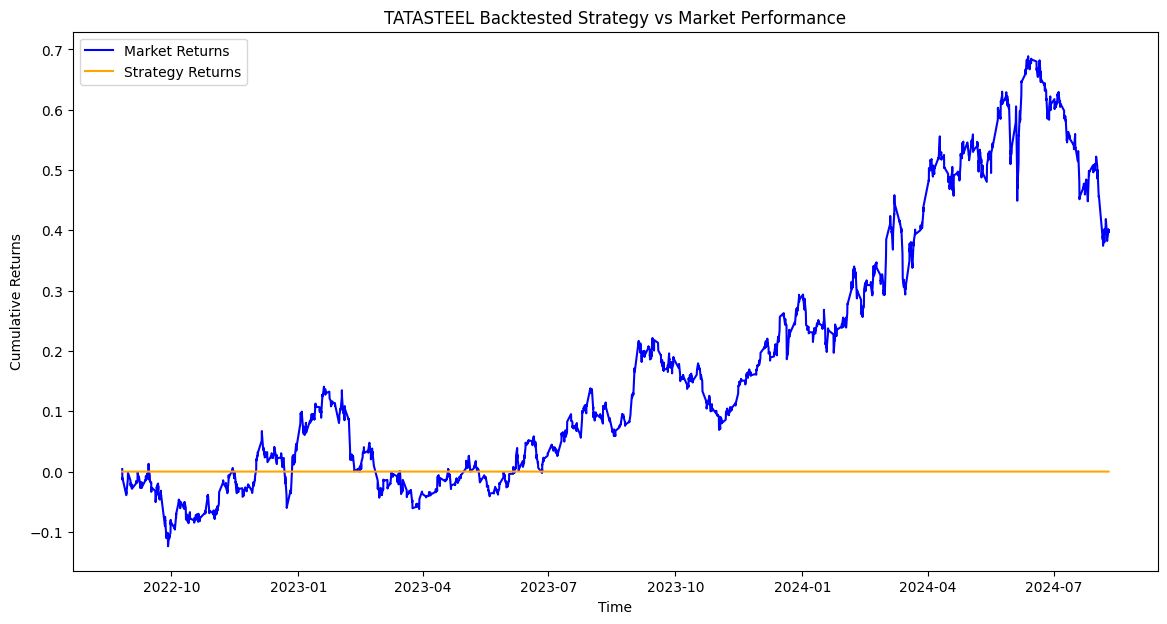

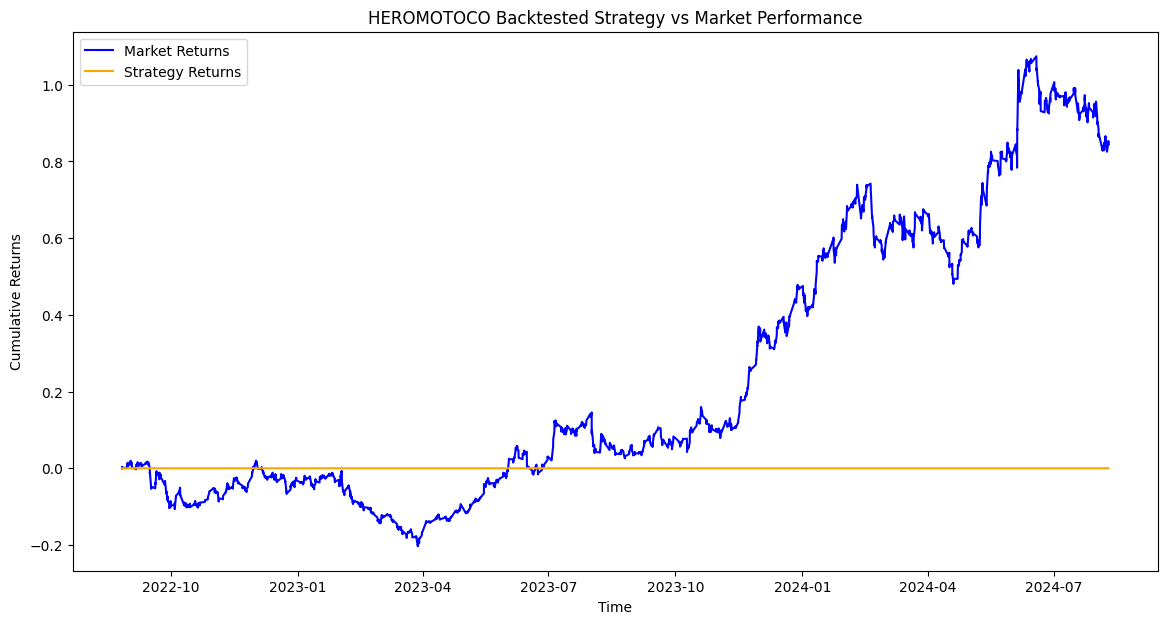

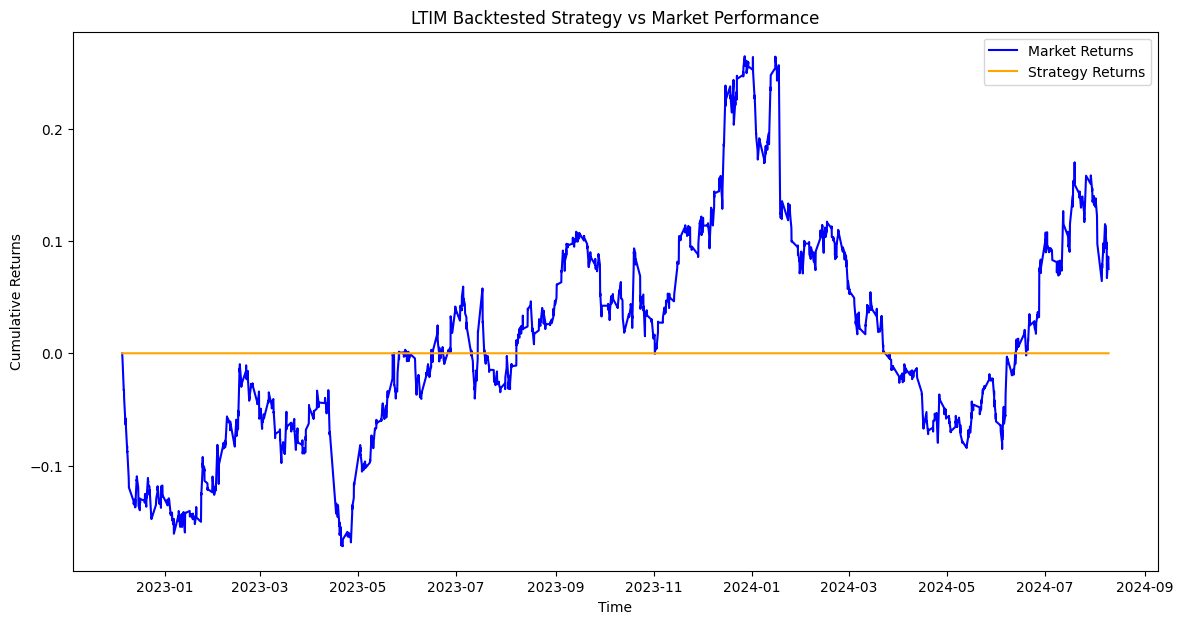

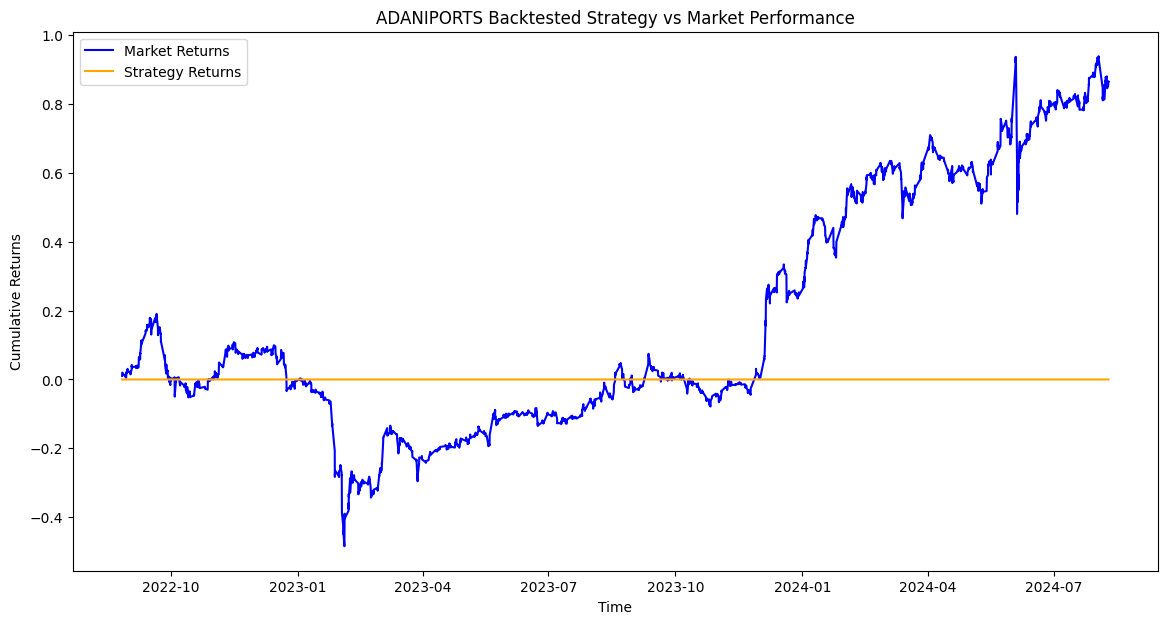

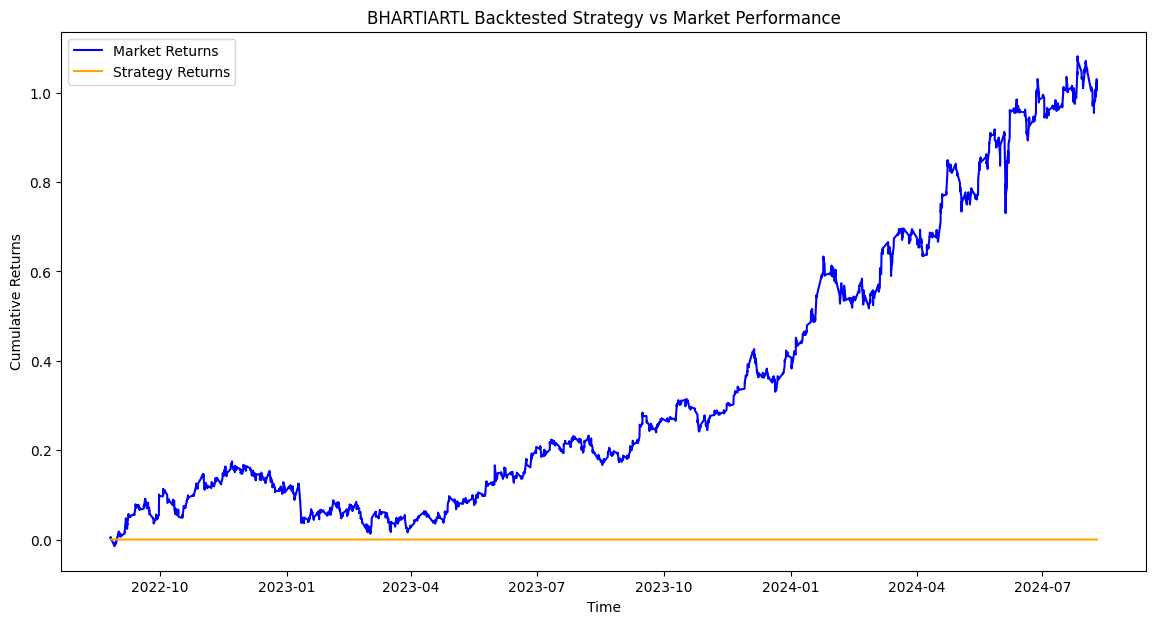

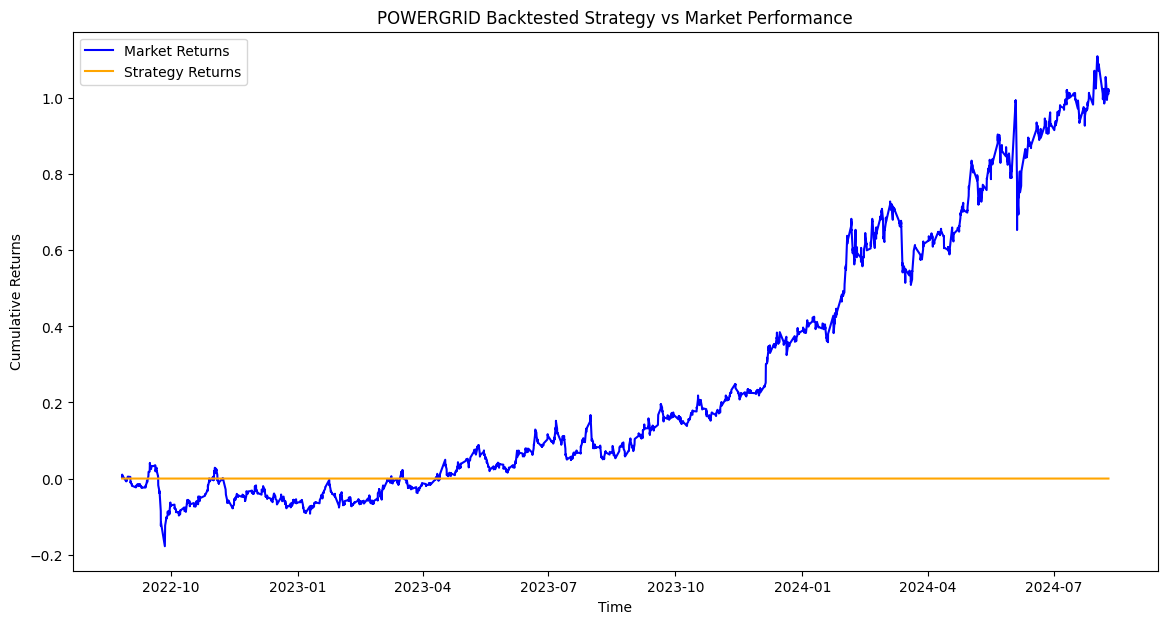

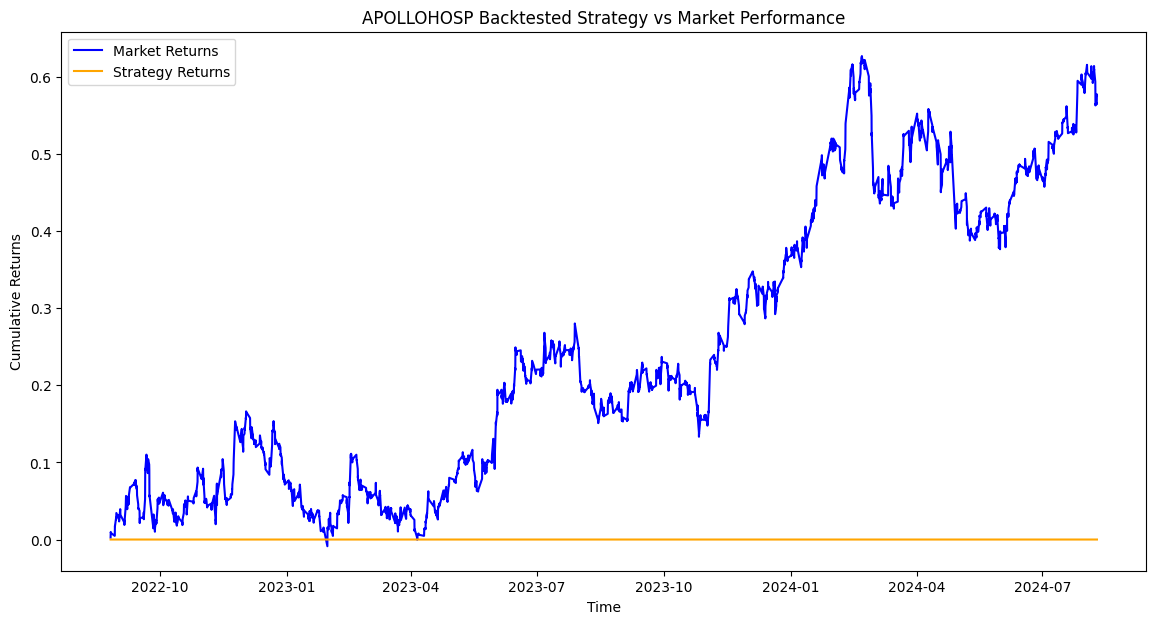

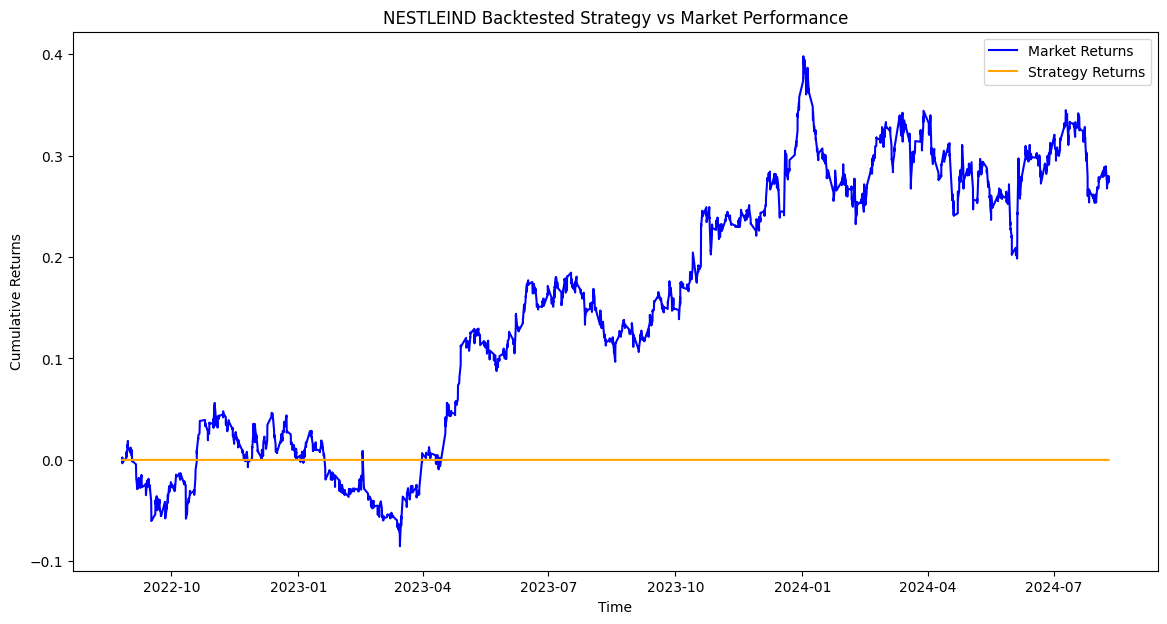

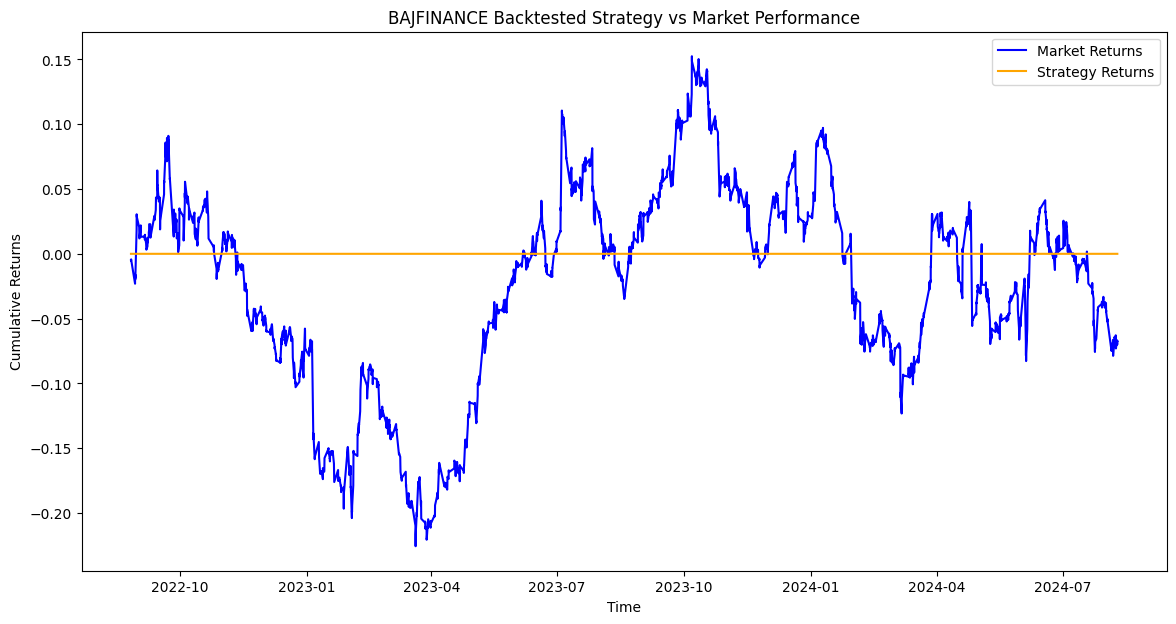

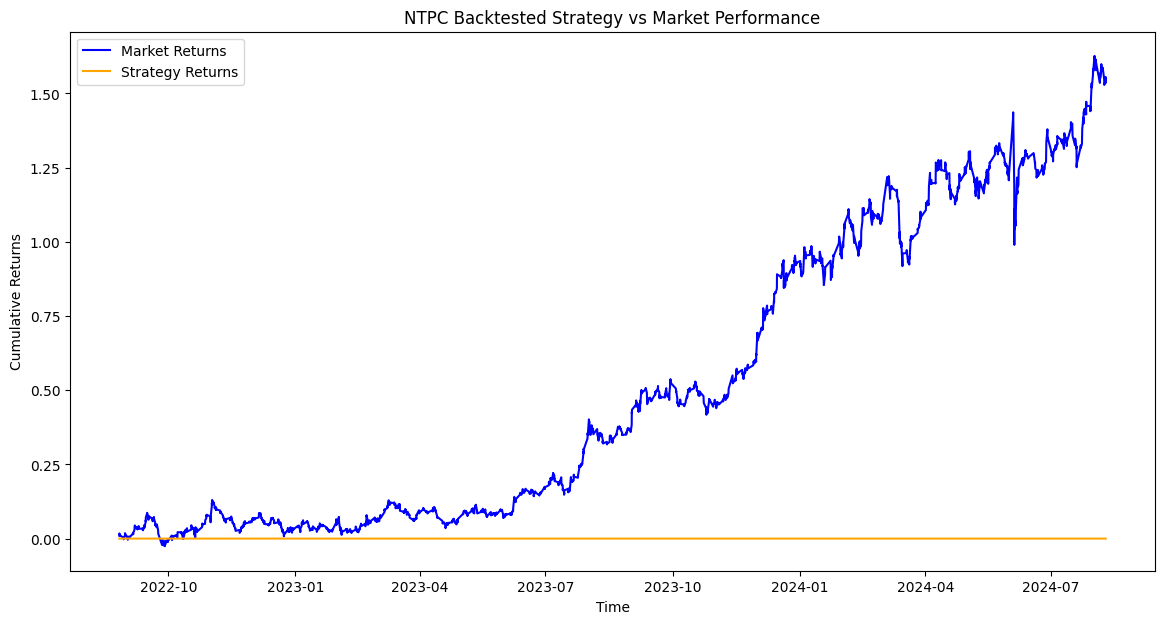

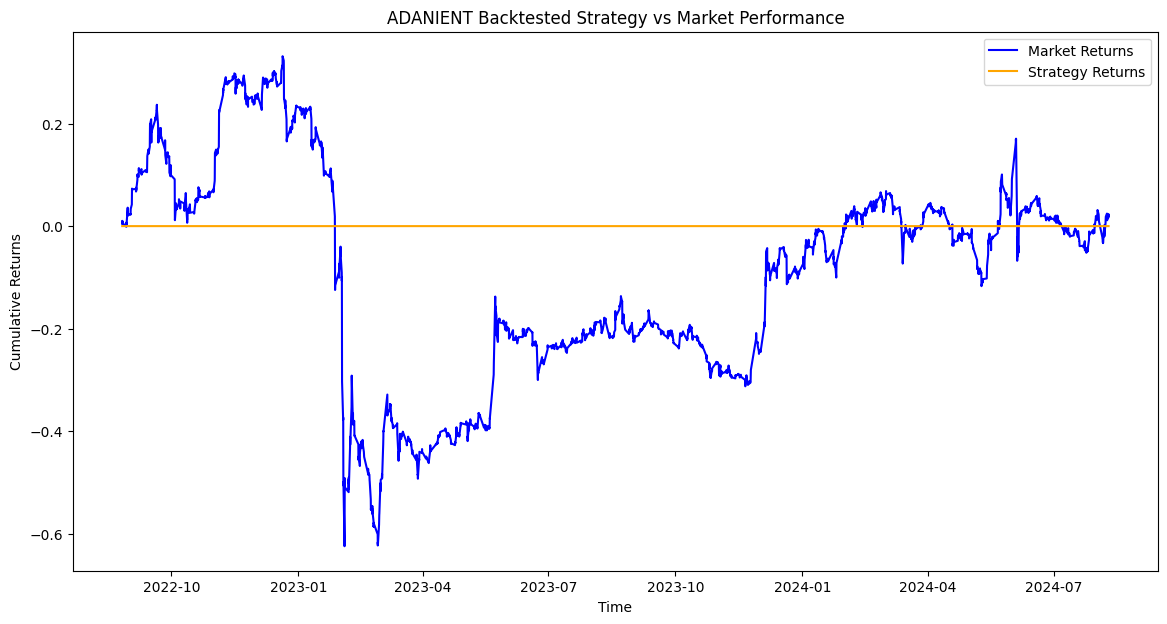

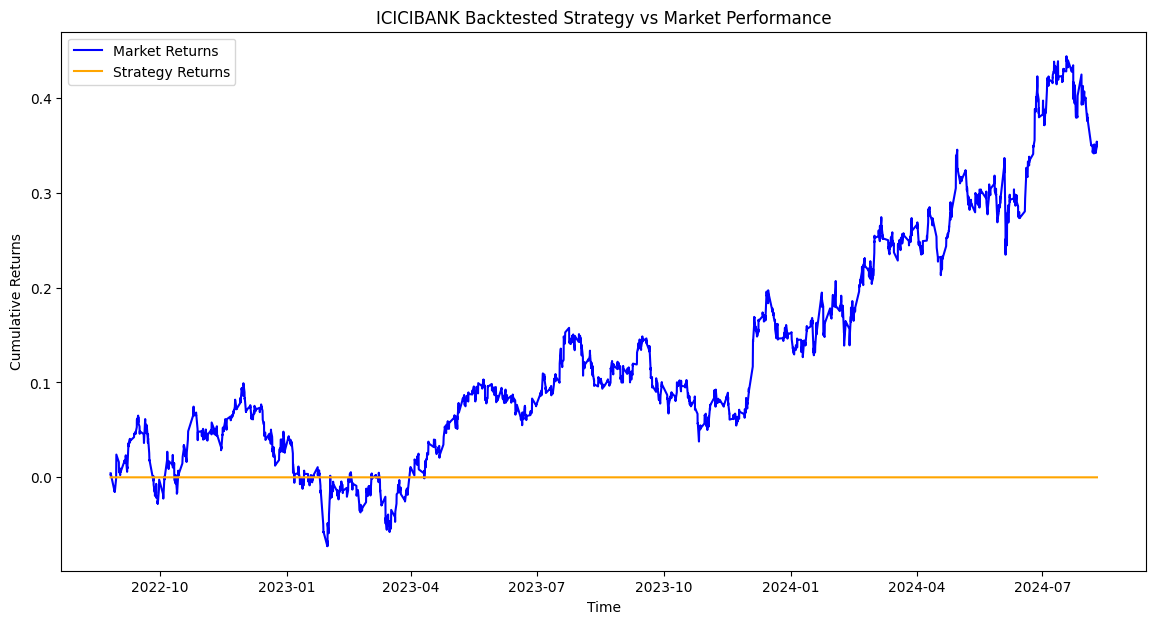

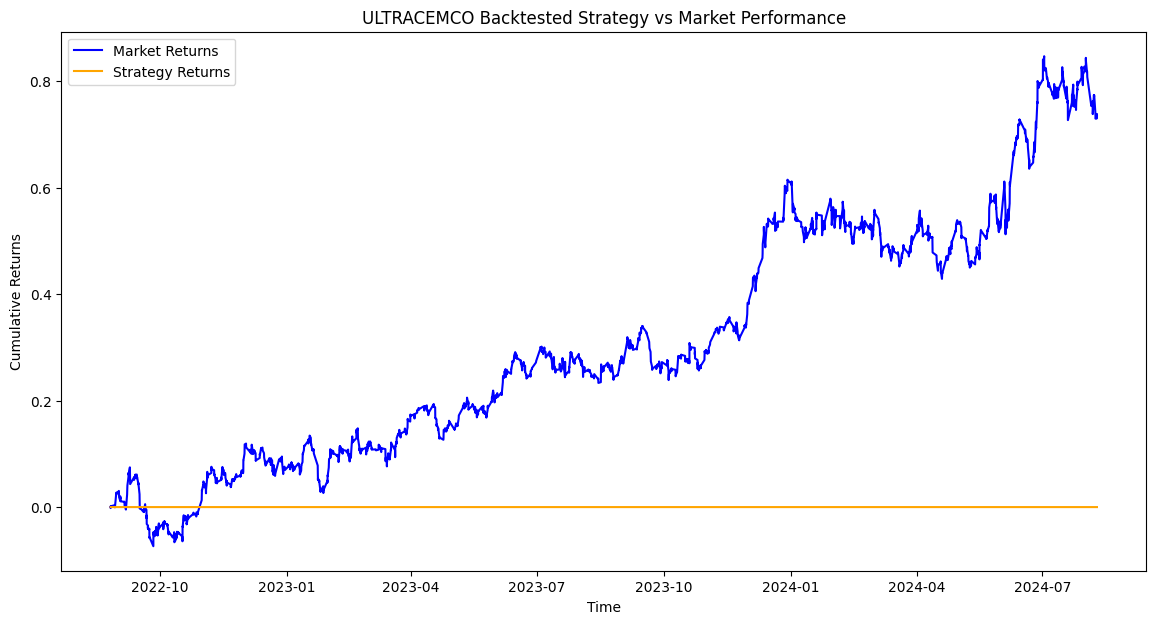

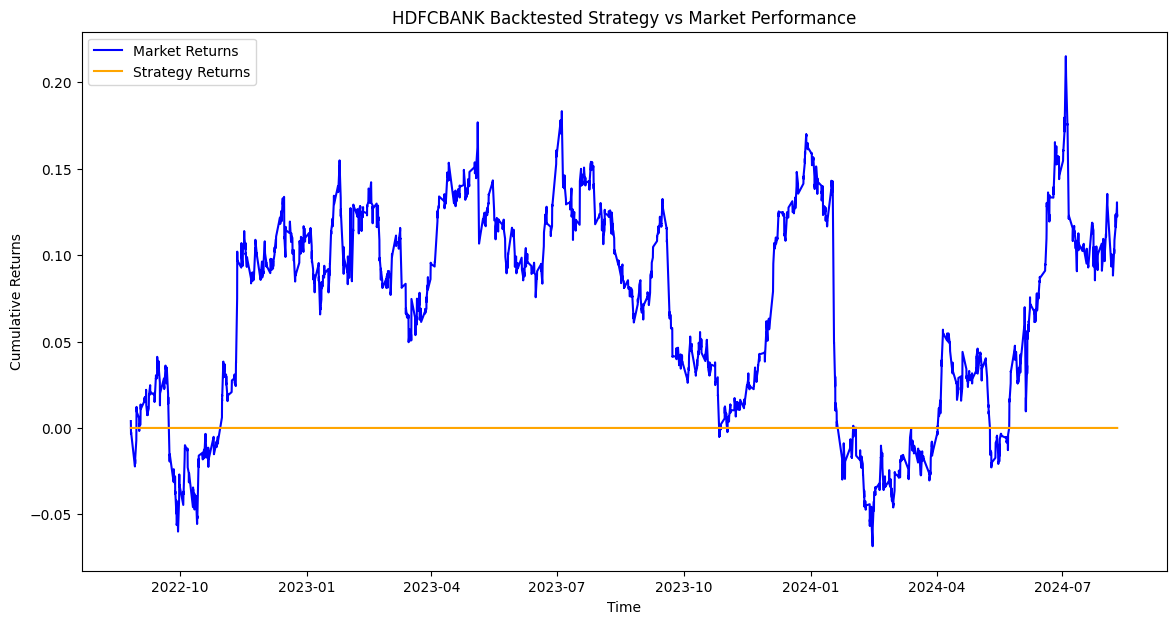

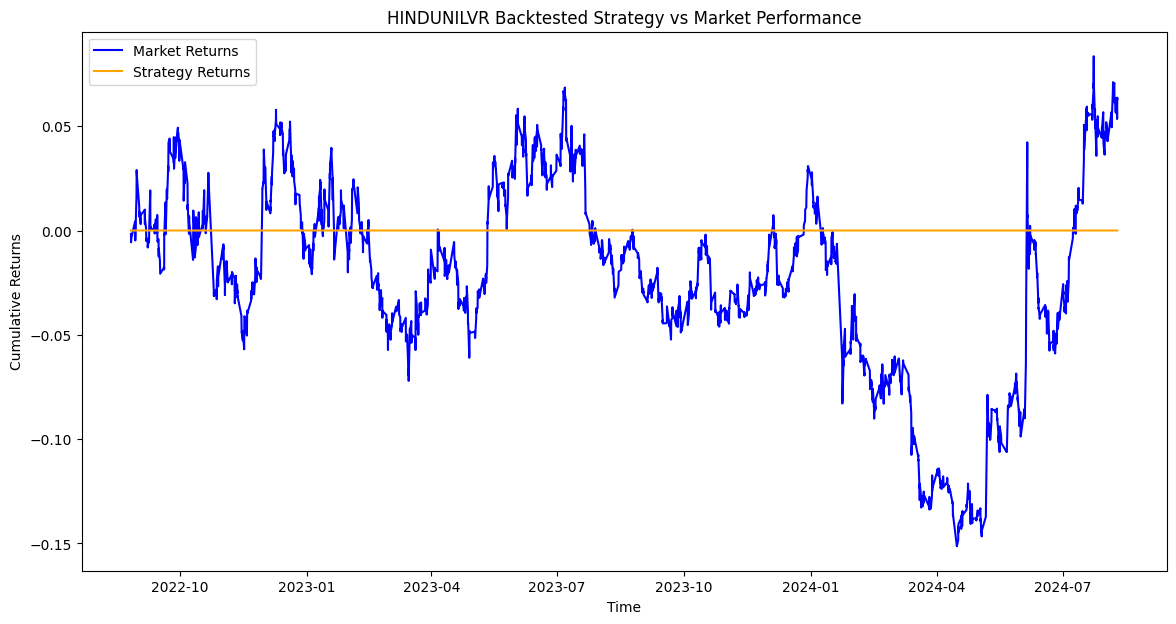

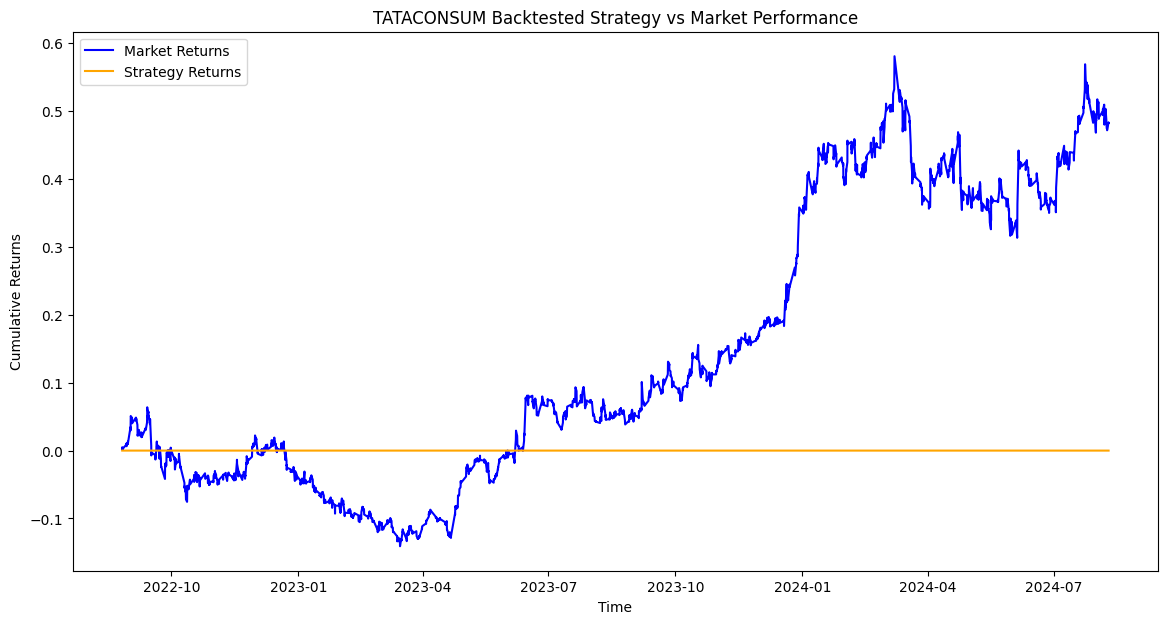

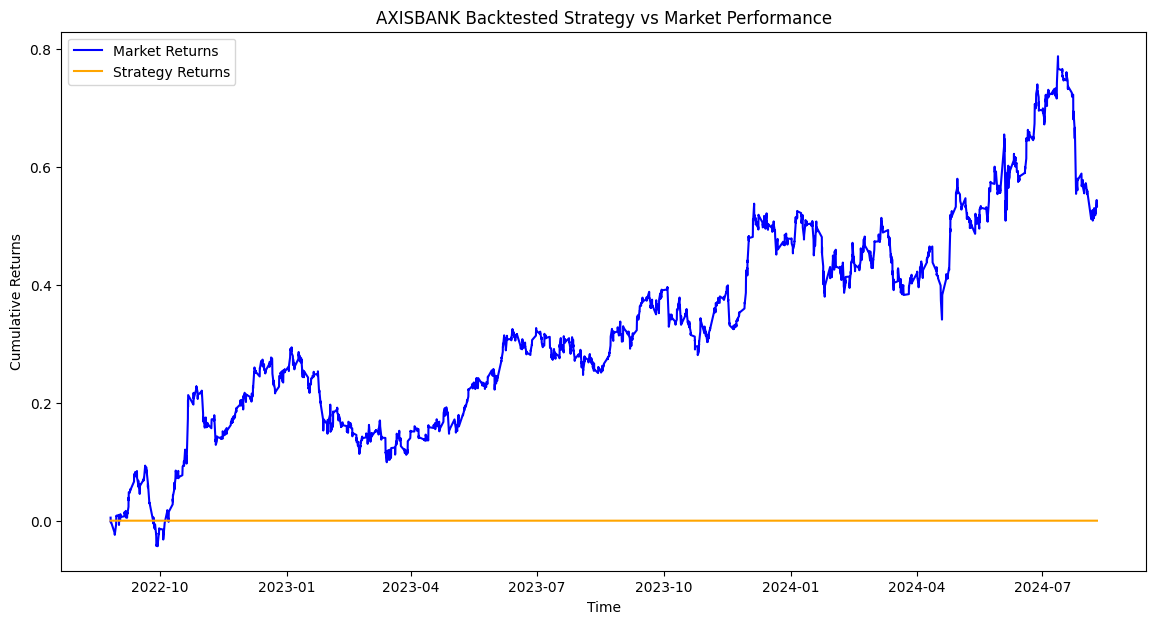

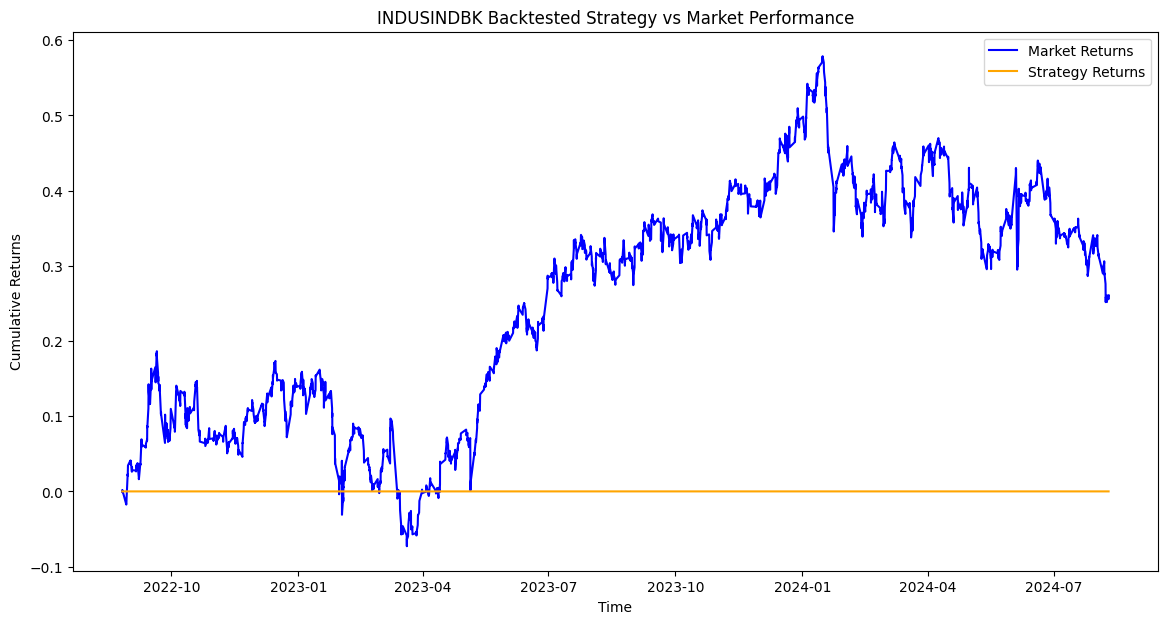

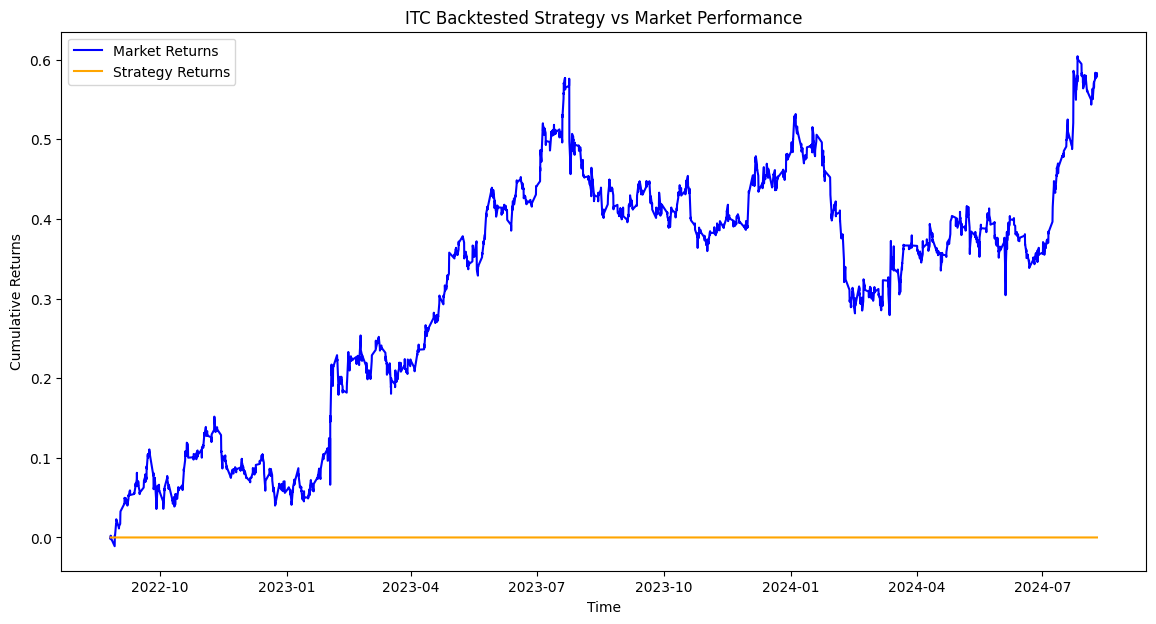

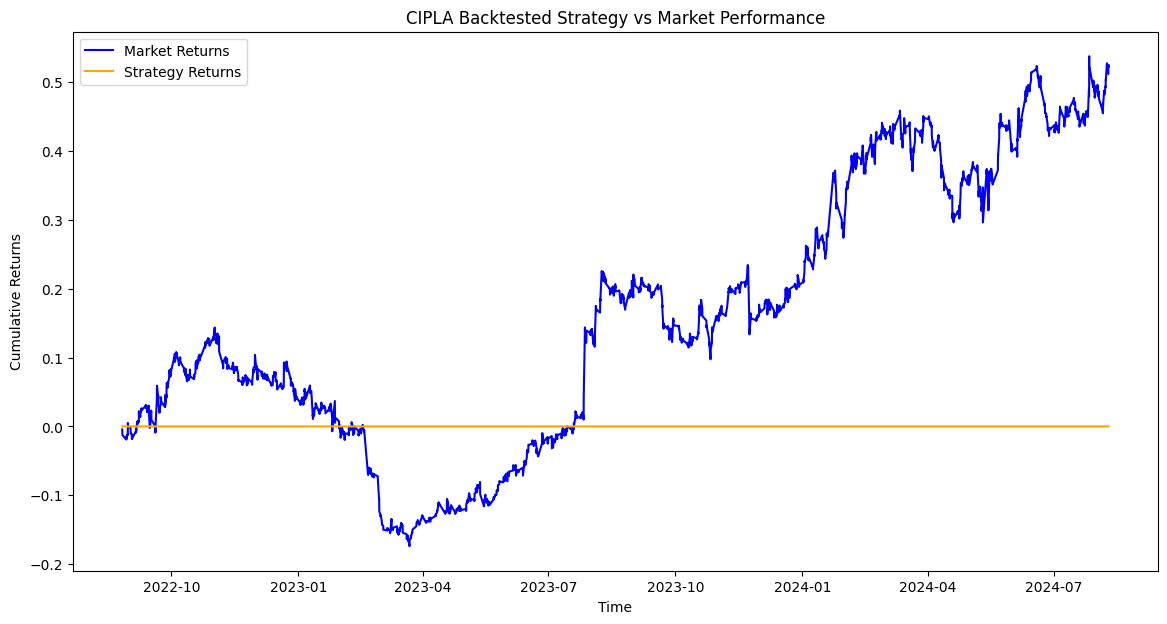

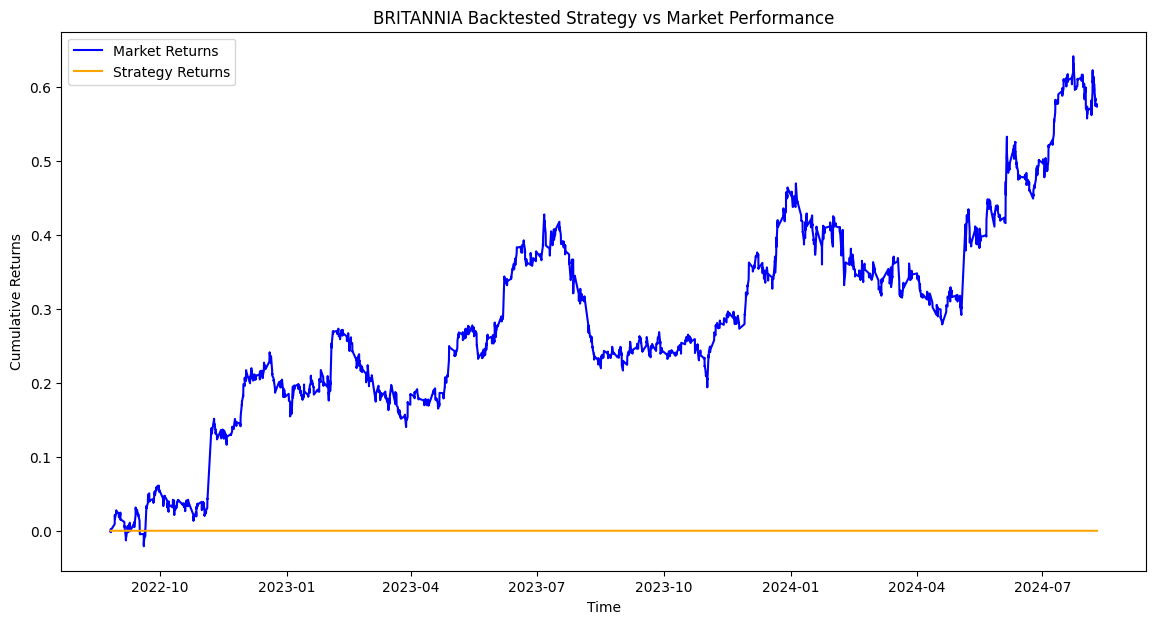

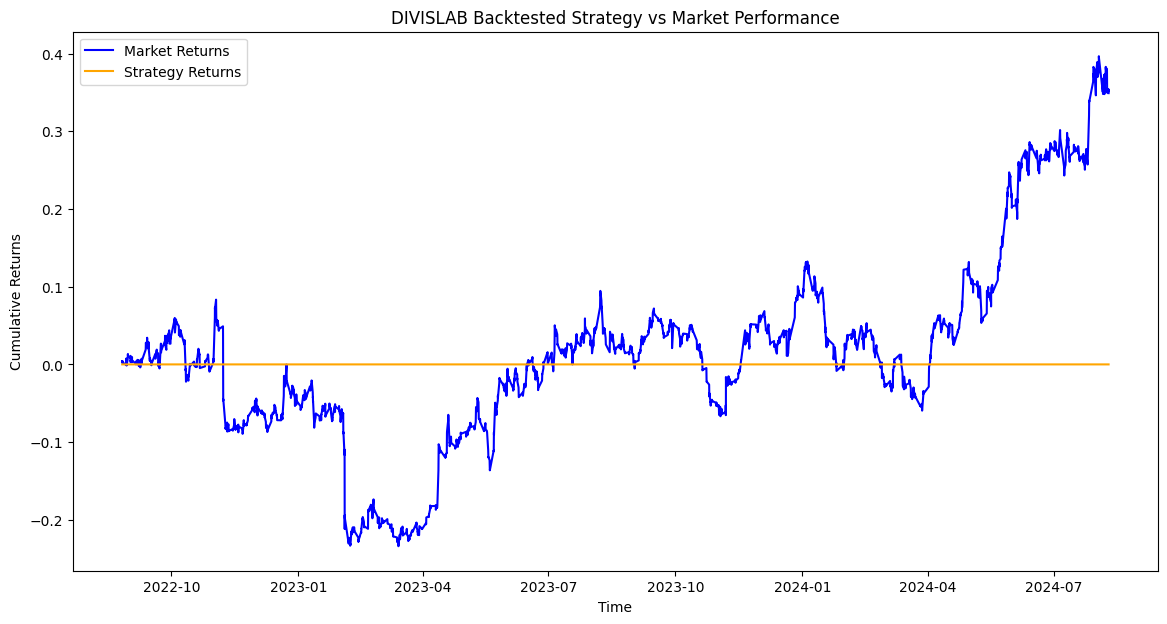

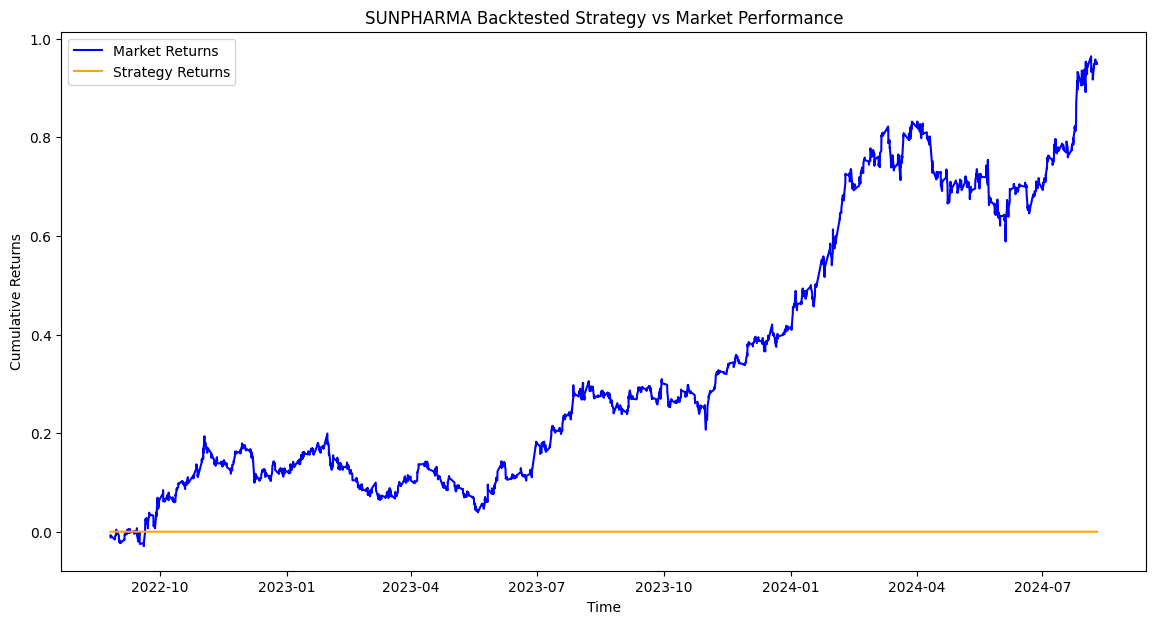

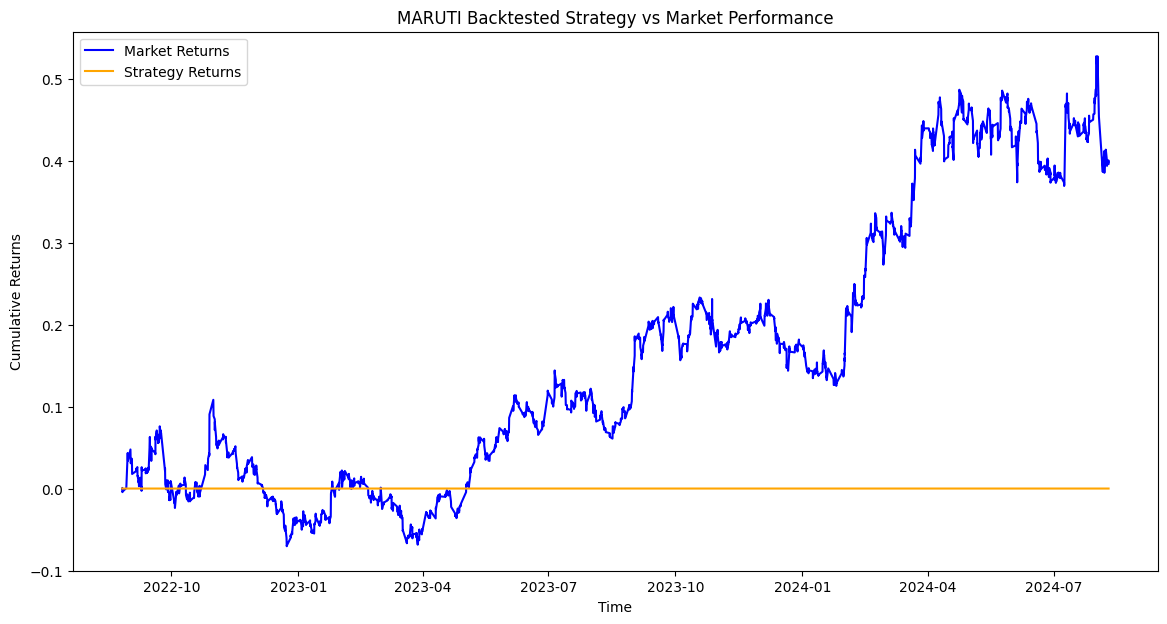

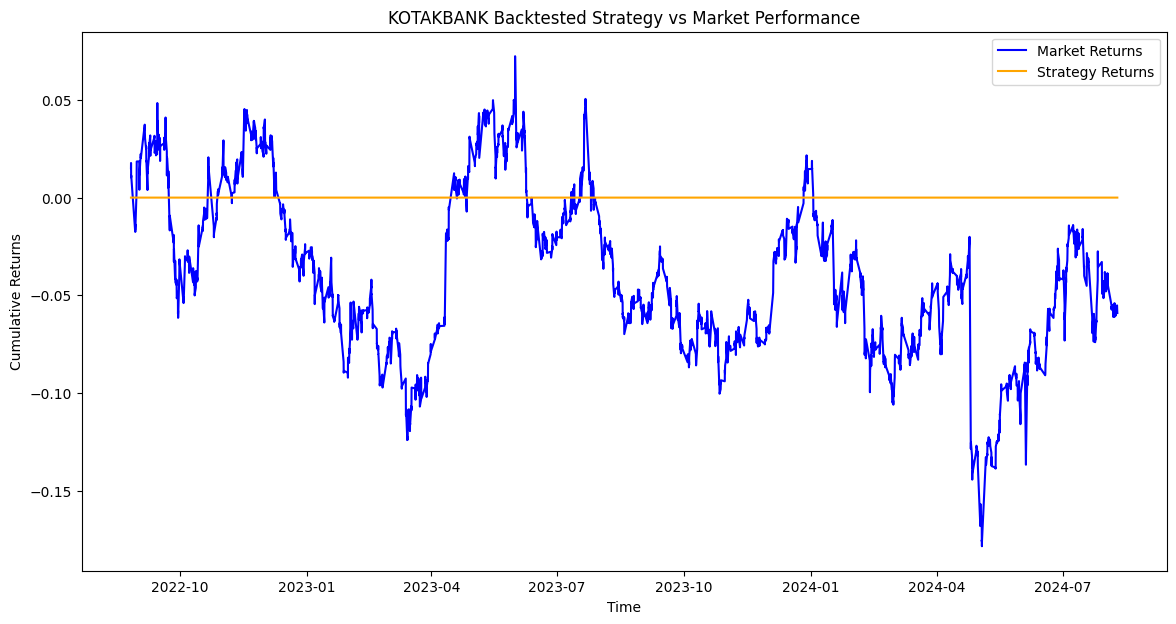

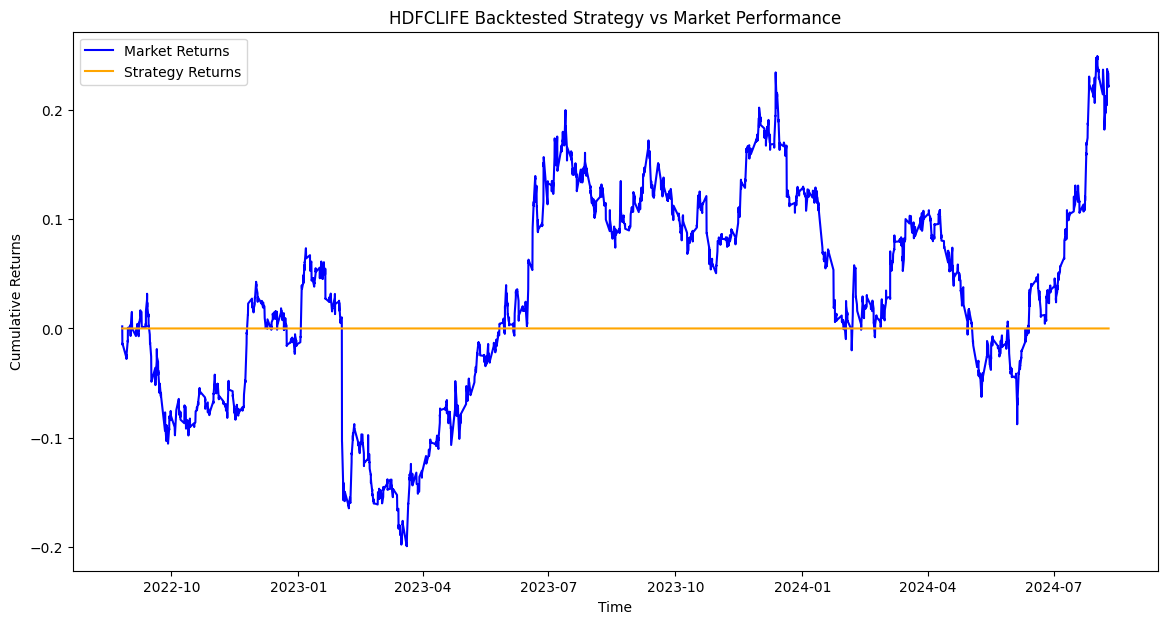

In [ ]:
bt_results = {}
trades_dict = {}
for ticker,data_df in data.items():
    result_df = pd.DataFrame(columns=['Market_Returns', 'Strategy_Returns', 'Cumulative_Market_Returns', 'Cumulative_Strategy_Returns'])
    try: 
        bt_result,entry_dict = ema_vwap_strategy_with_pivot(data_df,ticker)
        result_df['Market_Returns'] = bt_result['Market_Returns']
        result_df['Strategy_Returns'] = bt_result['Strategy_Returns']
        result_df['Cumulative_Market_Returns'] = bt_result['Cumulative_Market_Returns']
        result_df['Cumulative_Strategy_Returns'] = bt_result['Cumulative_Strategy_Returns']
        bt_results[ticker] = result_df
        trades_dict[ticker] = entry_dict
    except Exception as e:
        print(f'For ticker {ticker}: {e}')
    
    

In [ ]:
trades_dict

In [ ]:
for ticker, df in trades_dict.items():
    print(ticker,df)